In [1180]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import collections
from functools import partial
from aesthetics.plotting import adjust_spines
from tqdm import tqdm
from scipy.stats import multivariate_normal
from scipy.signal import convolve2d

# imports from tensorflow/models/tutorial/image/imagenet/classify_image.py
import argparse
import os.path
import re
import sys
import tarfile
from six.moves import urllib

# from deepdream notebook http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

plt.style.use('deepretina')

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Load VGG weights

In [52]:
vgg_weight_path = os.path.expanduser('~/data/vgg16-model/vgg16_weights.h5')
f = h5py.File(vgg_weight_path, 'r')

In [53]:
layer_names = []
layer_id = []
for layer in sorted(list(f.keys())):
    layer_names.append(layer)
    layer_id.append(int(layer.split('_')[-1]))
sorted_layer_names = np.array(layer_names)[np.argsort(layer_id)]

In [54]:
for layer in sorted_layer_names:
    if list(f[layer].keys()):
        print('%s : (%s, %s)' %(layer, *list(f[layer].keys())))
    else:
        print(layer)

layer_0
layer_1 : (param_0, param_1)
layer_2
layer_3 : (param_0, param_1)
layer_4
layer_5
layer_6 : (param_0, param_1)
layer_7
layer_8 : (param_0, param_1)
layer_9
layer_10
layer_11 : (param_0, param_1)
layer_12
layer_13 : (param_0, param_1)
layer_14
layer_15 : (param_0, param_1)
layer_16
layer_17
layer_18 : (param_0, param_1)
layer_19
layer_20 : (param_0, param_1)
layer_21
layer_22 : (param_0, param_1)
layer_23
layer_24
layer_25 : (param_0, param_1)
layer_26
layer_27 : (param_0, param_1)
layer_28
layer_29 : (param_0, param_1)
layer_30
layer_31
layer_32 : (param_0, param_1)
layer_33
layer_34 : (param_0, param_1)
layer_35
layer_36 : (param_0, param_1)


In [959]:
np.array(f['layer_32/param_0']).shape

(25088, 4096)

In [55]:
np.array(f['layer_3/param_0']).shape

(64, 64, 3, 3)

In [255]:
ground_W3 = np.array(f['layer_3/param_0']).copy()

In [256]:
blah = np.rollaxis(ground_W3, 0, 4)
blah = np.rollaxis(blah, 0, 3)
blah.shape

(3, 3, 64, 64)

In [257]:
ground_W1 = np.array(f['layer_1/param_0']).copy()
ground_W1.shape

(64, 3, 3, 3)

In [258]:
blah = np.rollaxis(ground_W1, 0, 4)
blah = np.rollaxis(blah, 0, 3)
blah.shape

(3, 3, 3, 64)

In [942]:
tf.reset_default_graph()

In [943]:
height, width = (15,15)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    
# X_mean, X_var = tf.nn.moments(X, axes=[0, 1, 2, 3])

# model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
# model.add(Convolution2D(64, 3, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(64, 3, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))    
# filter shape `[filter_height, filter_width, in_channels, out_channels]`
W1 = np.array(f['layer_1/param_0']).copy()
W1 = np.rollaxis(W1, 0, 4)
W1 = np.rollaxis(W1, 0, 3)
# X_normed = (X - X_mean)/tf.sqrt(X_var)
X_clipped = tf.clip_by_value(X, -128., 128.)
W1x = tf.nn.conv2d(X_clipped, W1, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W1x = tf.nn.relu(W1x + np.array(f['layer_1/param_1']))
W3 = np.array(f['layer_3/param_0']).copy()
W3 = np.rollaxis(W3, 0, 4)
W3 = np.rollaxis(W3, 0, 3)
# W3 = np.rollaxis(W3)
W3x = tf.nn.conv2d(relu_W1x, W3, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W3x = tf.nn.relu(W3x + np.array(f['layer_3/param_1']))

In [944]:
selected_unit = 0
l2_reg = 1e-1
# activity = -tf.nn.l2_loss(relu_W3x[0,:,:,selected_unit]) + l2_reg*(tf.nn.l2_loss(X))
# desirable_activity = -tf.nn.l2_loss(relu_W3x[0,:,:,selected_unit])
desirable_activity = -tf.nn.l2_loss(relu_W3x[0,:,:,selected_unit])
# undesirable_activity = -l2_reg
# undesirable_activity = -l2_reg*(tf.nn.l2_loss(relu_W3x[0,:,:,:selected_unit]) + tf.nn.l2_loss(relu_W3x[0,:,:,(selected_unit+1):]))

lr = tf.placeholder(tf.float32, shape=[])
opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
# grads = opt.compute_gradients(desirable_activity - undesirable_activity)
grads = opt.compute_gradients(desirable_activity)
train_op = opt.apply_gradients(grads)
# train_op = opt.minimize(loss)

In [945]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

iterations = 1000
this_lr = 10.

grad_history = []
activation_history = []
regularization_history = []
input_variance_history = []
for it in tqdm(range(iterations)):
    g = sess.run([train_op, grads, desirable_activity], feed_dict={lr: this_lr})#, undesirable_activity]) #, X_var
    grad_history.append(g[1])
    activation_history.append(g[2])
    
    if it % 500 == 0:
        this_lr *= 0.1
        
#     regularization_history.append(g[3])
#     input_variance_history.append(g[4])

100%|██████████| 1000/1000 [00:02<00:00, 453.65it/s]


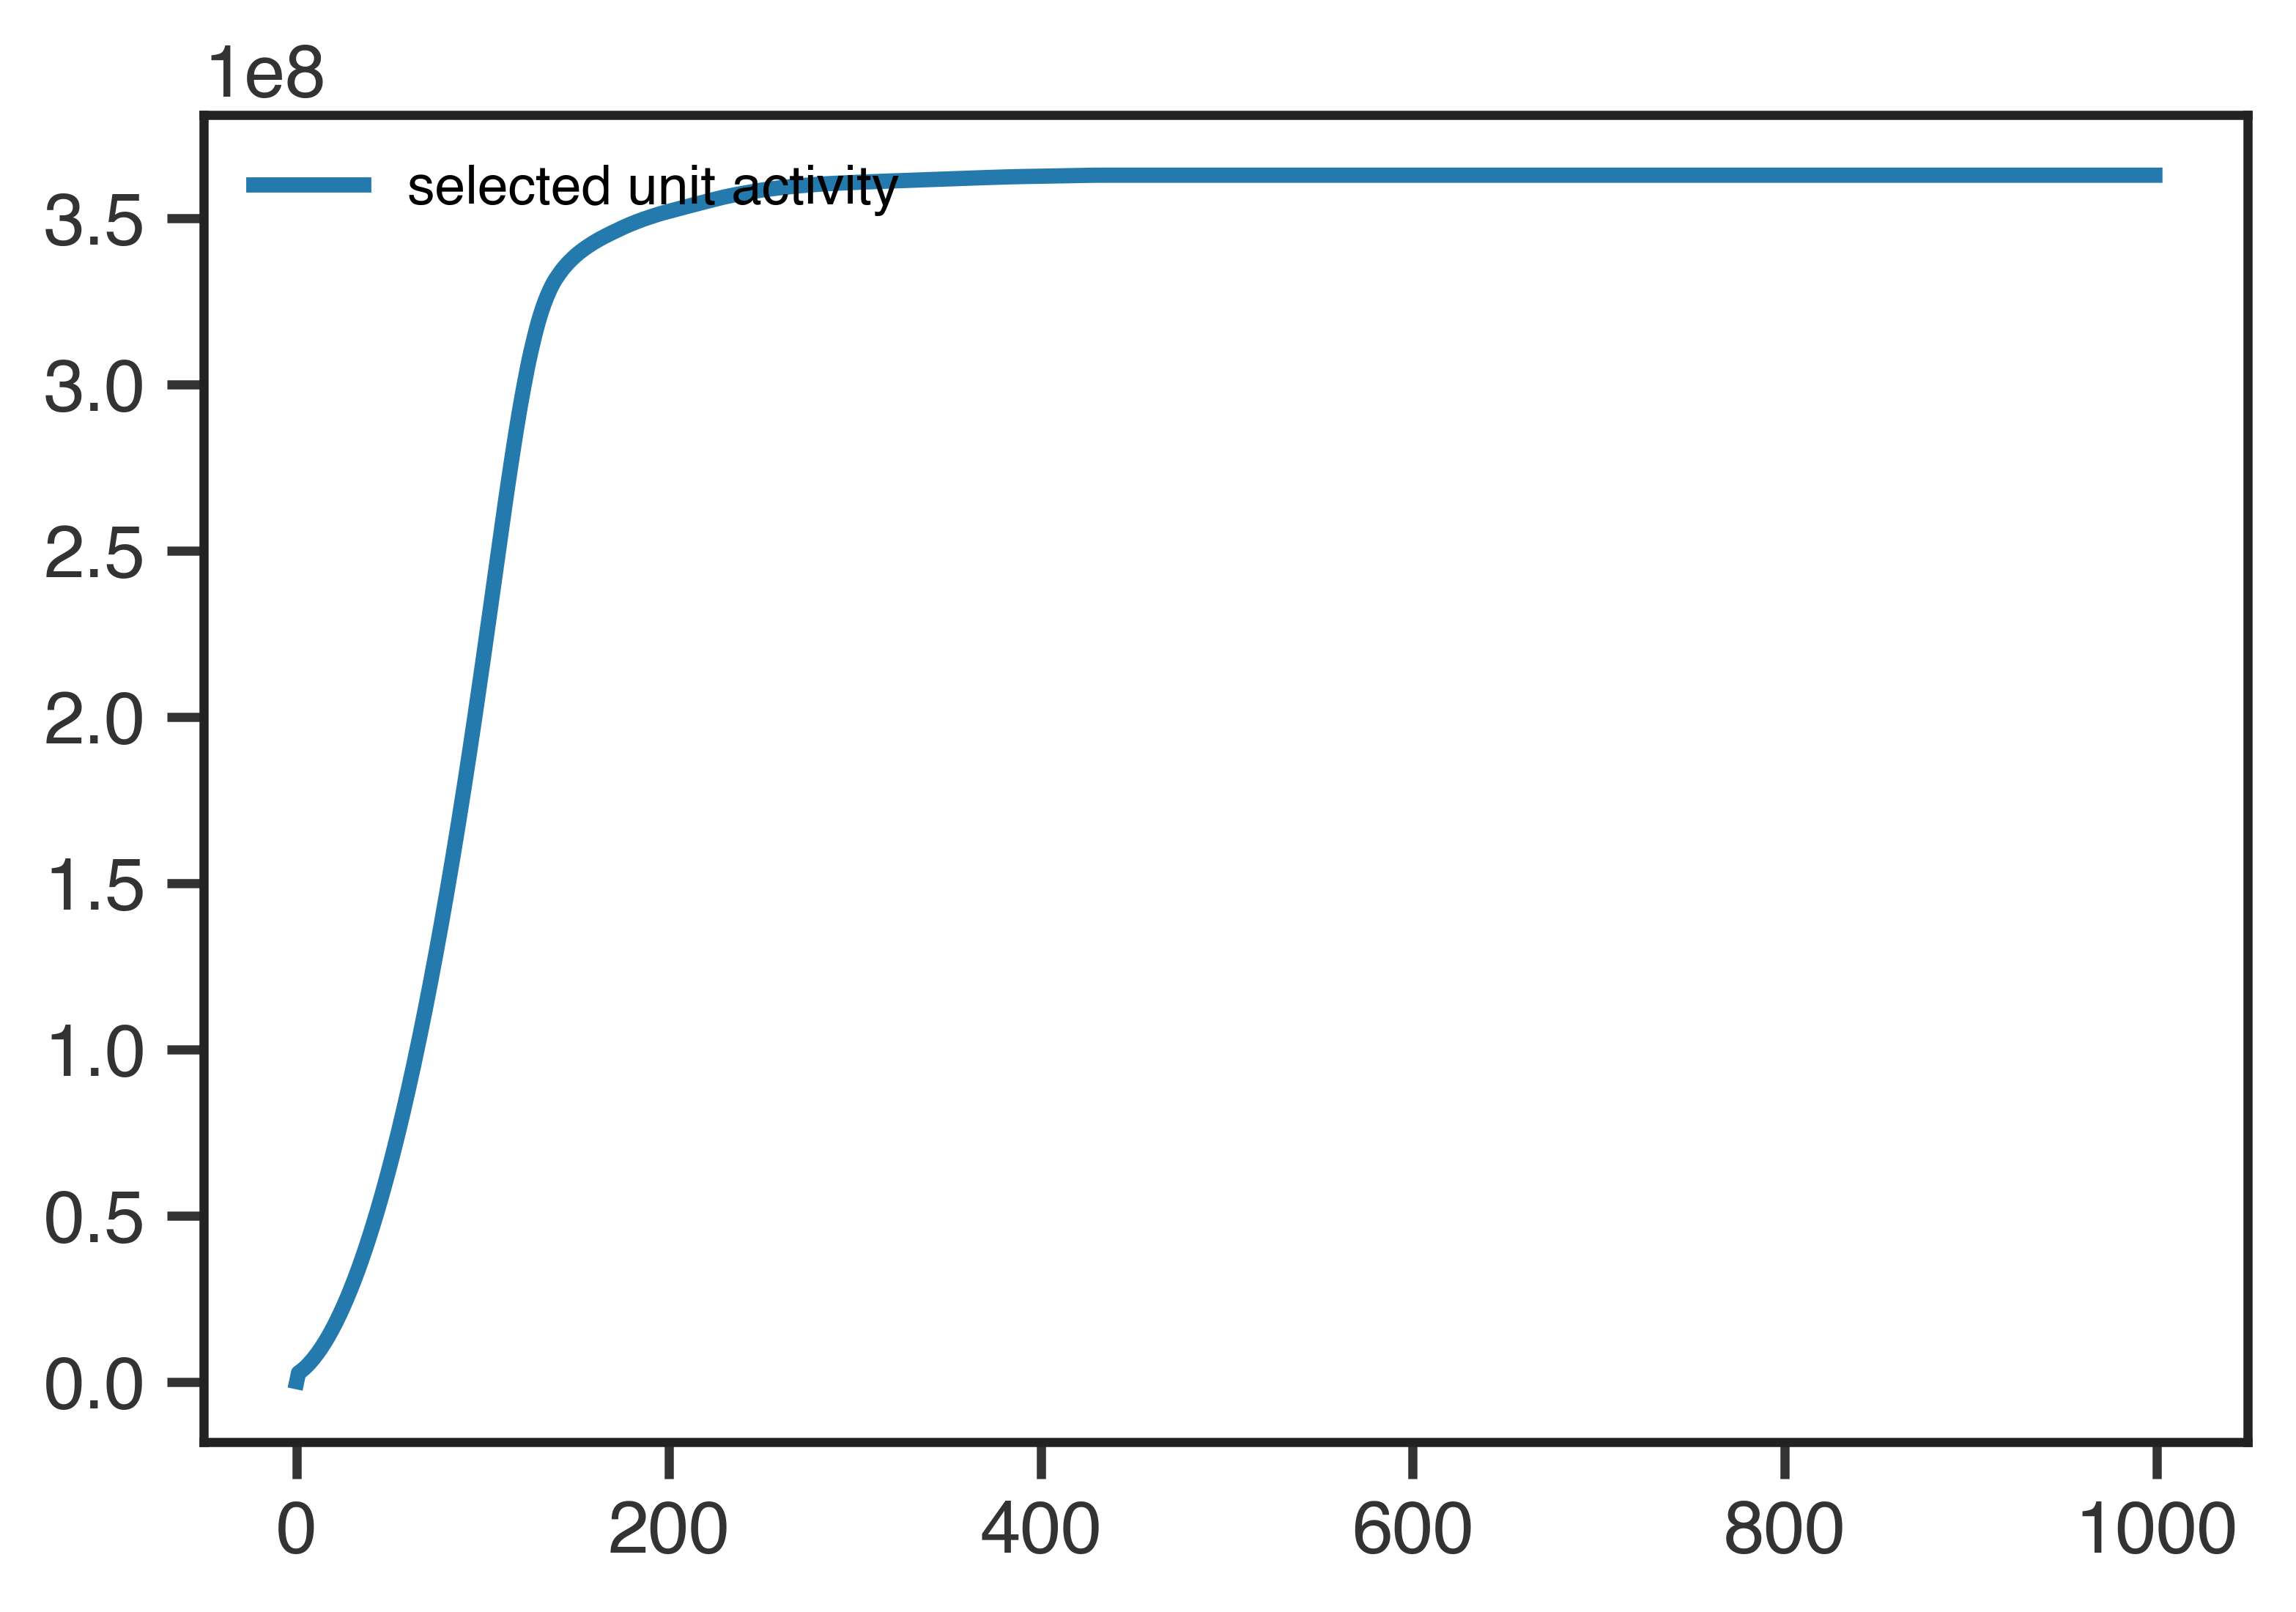

In [946]:
plt.plot(-np.array(activation_history), label='selected unit activity')
# plt.plot(-np.array(regularization_history), label='other activity')
# plt.plot(np.array(activation_history) - np.array(regularization_history), label='loss function')
plt.legend(loc='upper left', frameon=False, fontsize=9)
# plt.yscale('log')

In [947]:
# plt.plot(-np.array(regularization_history))

In [948]:
# plt.plot(-np.array(activation_history))

In [949]:
maximal_image = sess.run(X)
# maximal_image = sess.run(X_clipped)

In [950]:
(np.min(maximal_image[0,:,:,:]), np.max(maximal_image[0,:,:,:]))

(-279.93497, 278.98453)

In [951]:
maximal_image[0,:,:,:].shape

(15, 15, 3)

(-0.5, 14.5, 14.5, -0.5)

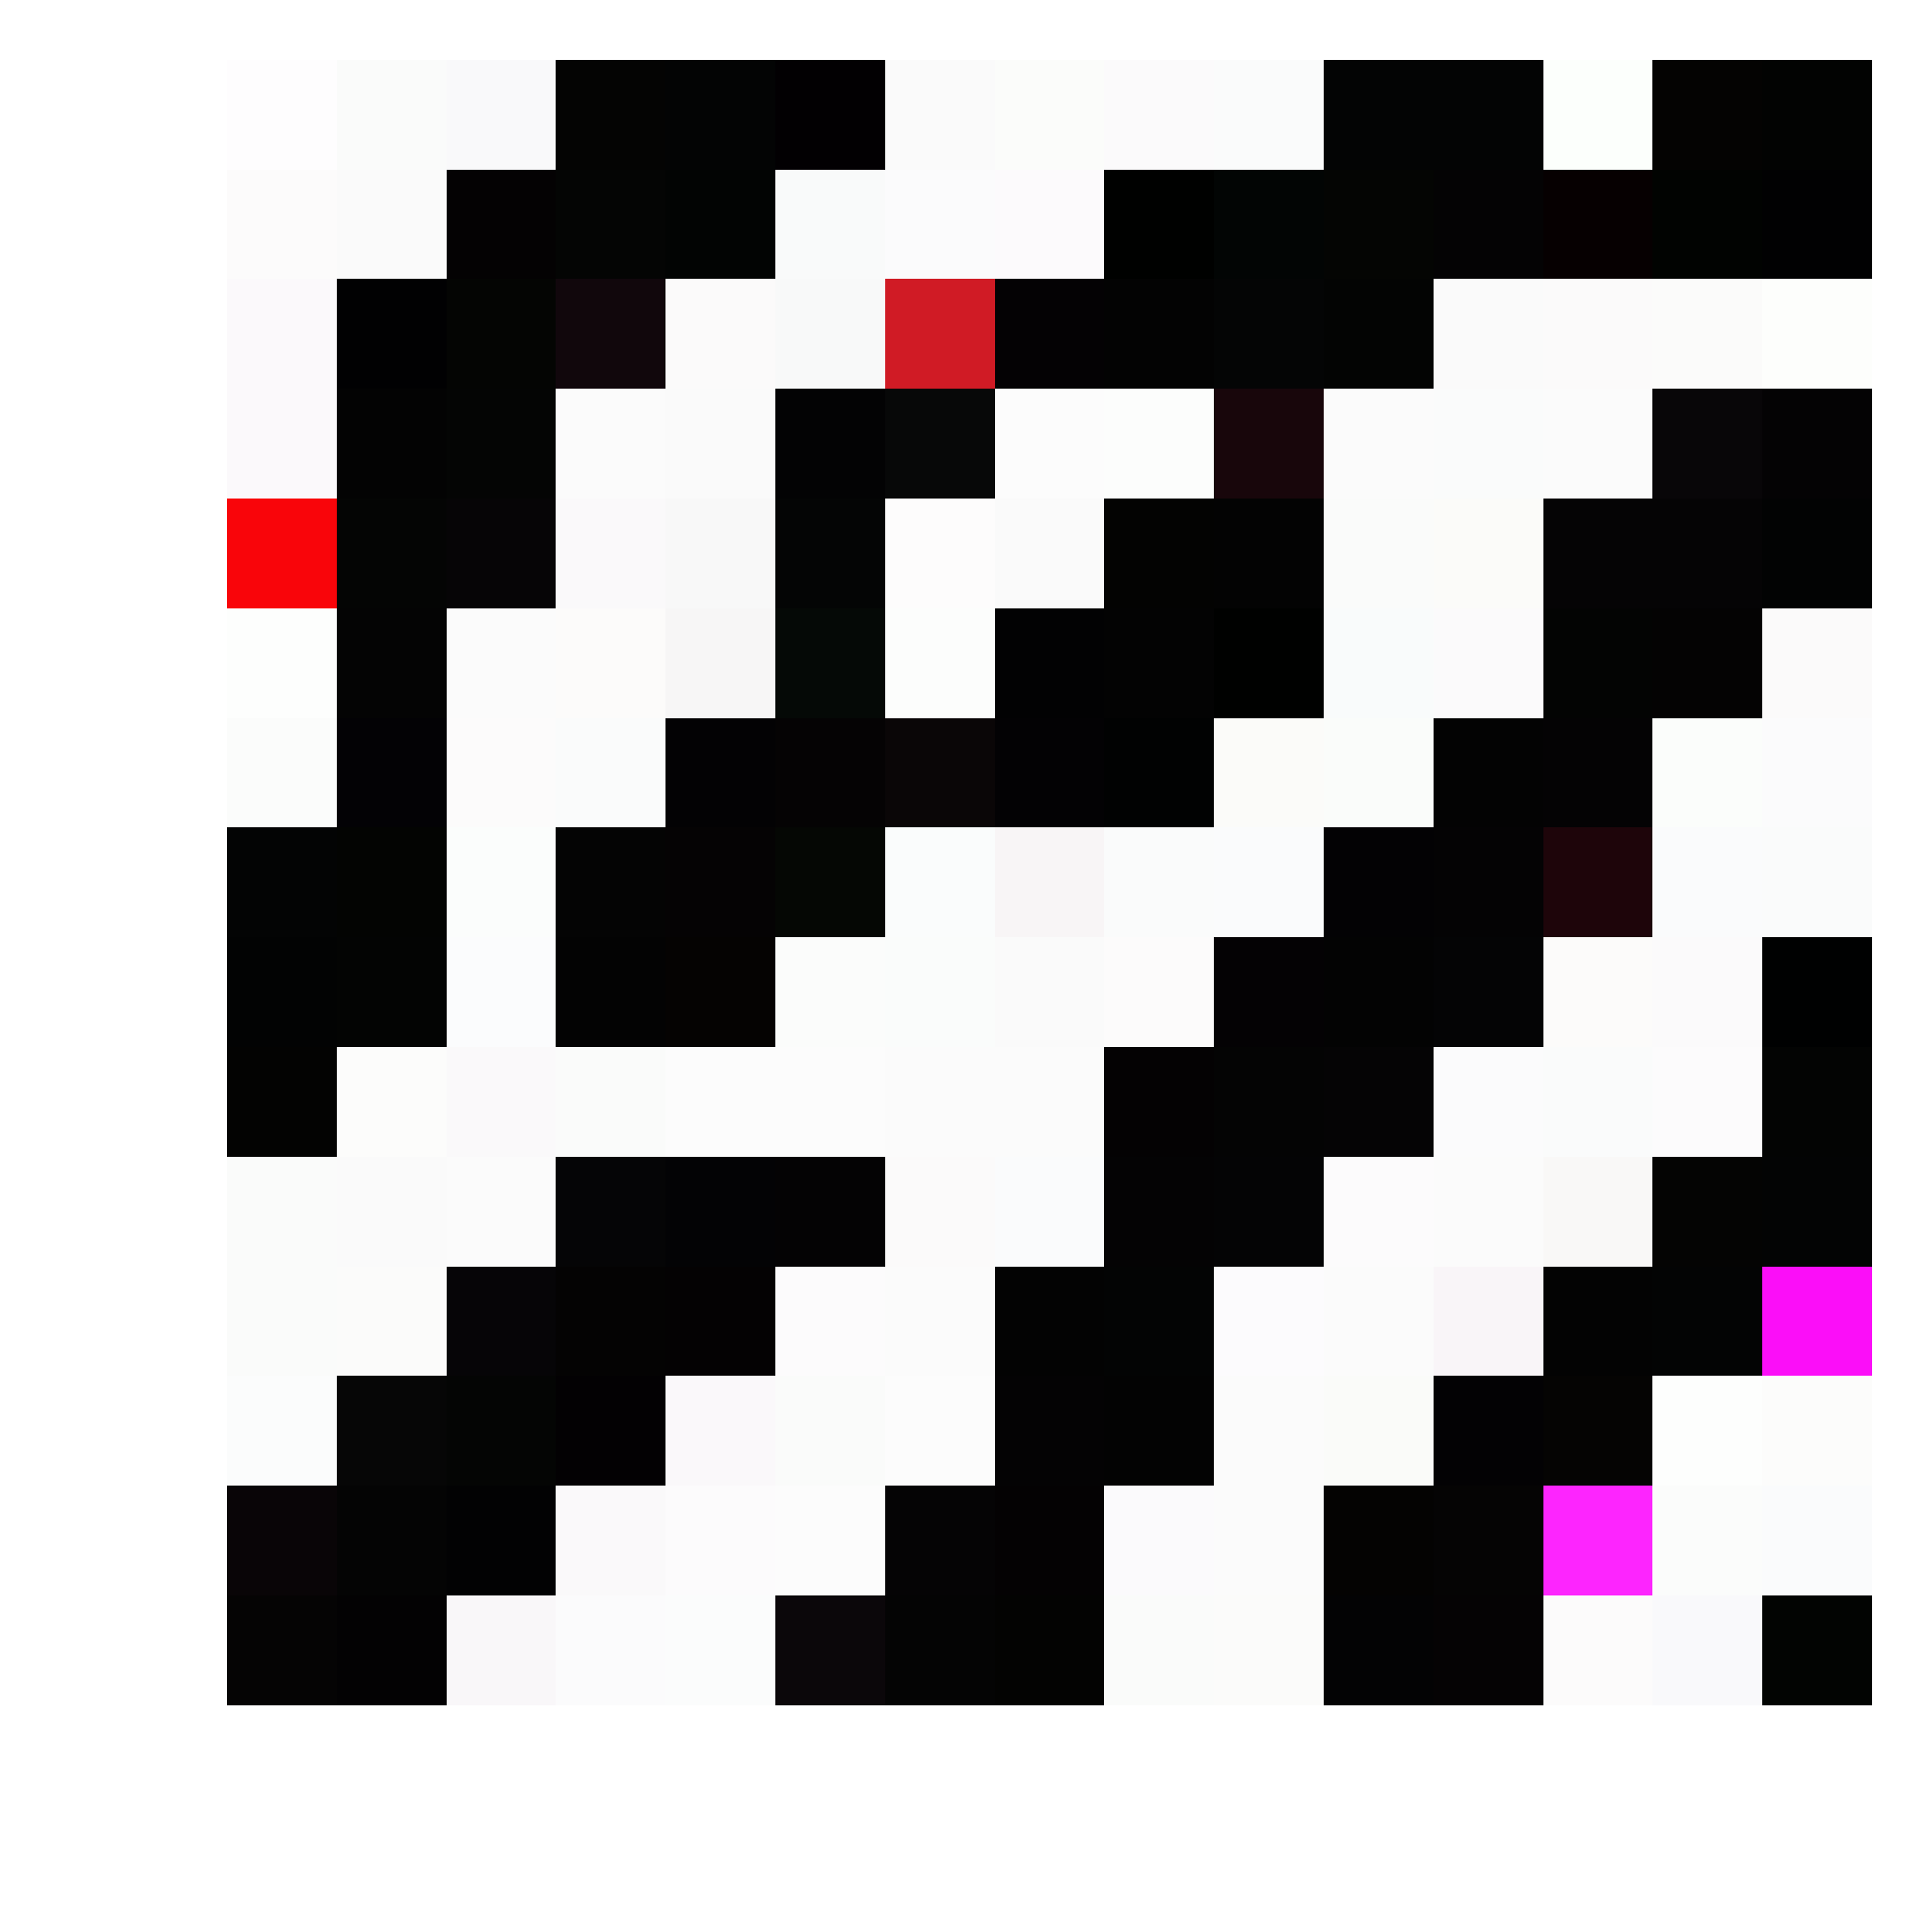

In [952]:
rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
rescaled_img /= np.max(rescaled_img)
plt.imshow(rescaled_img)
plt.axis('off')

# W1 maps

In [ ]:
activity_maps = collections.defaultdict(list)
for i in tqdm(range(64)):
    tf.reset_default_graph()
    height, width = (15,15)
    with tf.variable_scope('input'):
        # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
        X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))

    # filter shape `[filter_height, filter_width, in_channels, out_channels]`
    W1 = np.array(f['layer_1/param_0']).copy()
    W1 = np.rollaxis(W1, 0, 4)
    W1 = np.rollaxis(W1, 0, 3)
    X_clipped = tf.clip_by_value(X, -128., 128.)
    W1x = tf.nn.conv2d(X_clipped, W1, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
    relu_W1x = tf.nn.relu(W1x + np.array(f['layer_1/param_1']))
        
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(relu_W1x[0,:,:,selected_unit])

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    grad_history = []
    activation_history = []
    regularization_history = []
    input_variance_history = []
    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    activity_maps['layer_1'].append(rescaled_img)

# W3 maps

In [955]:
activity_maps = collections.defaultdict(list)
for i in tqdm(range(64)):
    tf.reset_default_graph()
    height, width = (15,15)
    with tf.variable_scope('input'):
        # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
        X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))

    # filter shape `[filter_height, filter_width, in_channels, out_channels]`
    W1 = np.array(f['layer_1/param_0']).copy()
    W1 = np.rollaxis(W1, 0, 4)
    W1 = np.rollaxis(W1, 0, 3)
    X_clipped = tf.clip_by_value(X, -128., 128.)
    W1x = tf.nn.conv2d(X_clipped, W1, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
    relu_W1x = tf.nn.relu(W1x + np.array(f['layer_1/param_1']))
    
    W3 = np.array(f['layer_3/param_0']).copy()
    W3 = np.rollaxis(W3, 0, 4)
    W3 = np.rollaxis(W3, 0, 3)
    W3x = tf.nn.conv2d(relu_W1x, W3, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
    relu_W3x = tf.nn.relu(W3x + np.array(f['layer_3/param_1']))
    
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(relu_W3x[0,:,:,selected_unit])

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    grad_history = []
    activation_history = []
    regularization_history = []
    input_variance_history = []
    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    activity_maps['layer_3'].append(rescaled_img)

100%|██████████| 64/64 [02:21<00:00,  2.38s/it]


In [975]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(activity_maps['layer_3']):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m

(-0.5, 128.5, 128.5, -0.5)

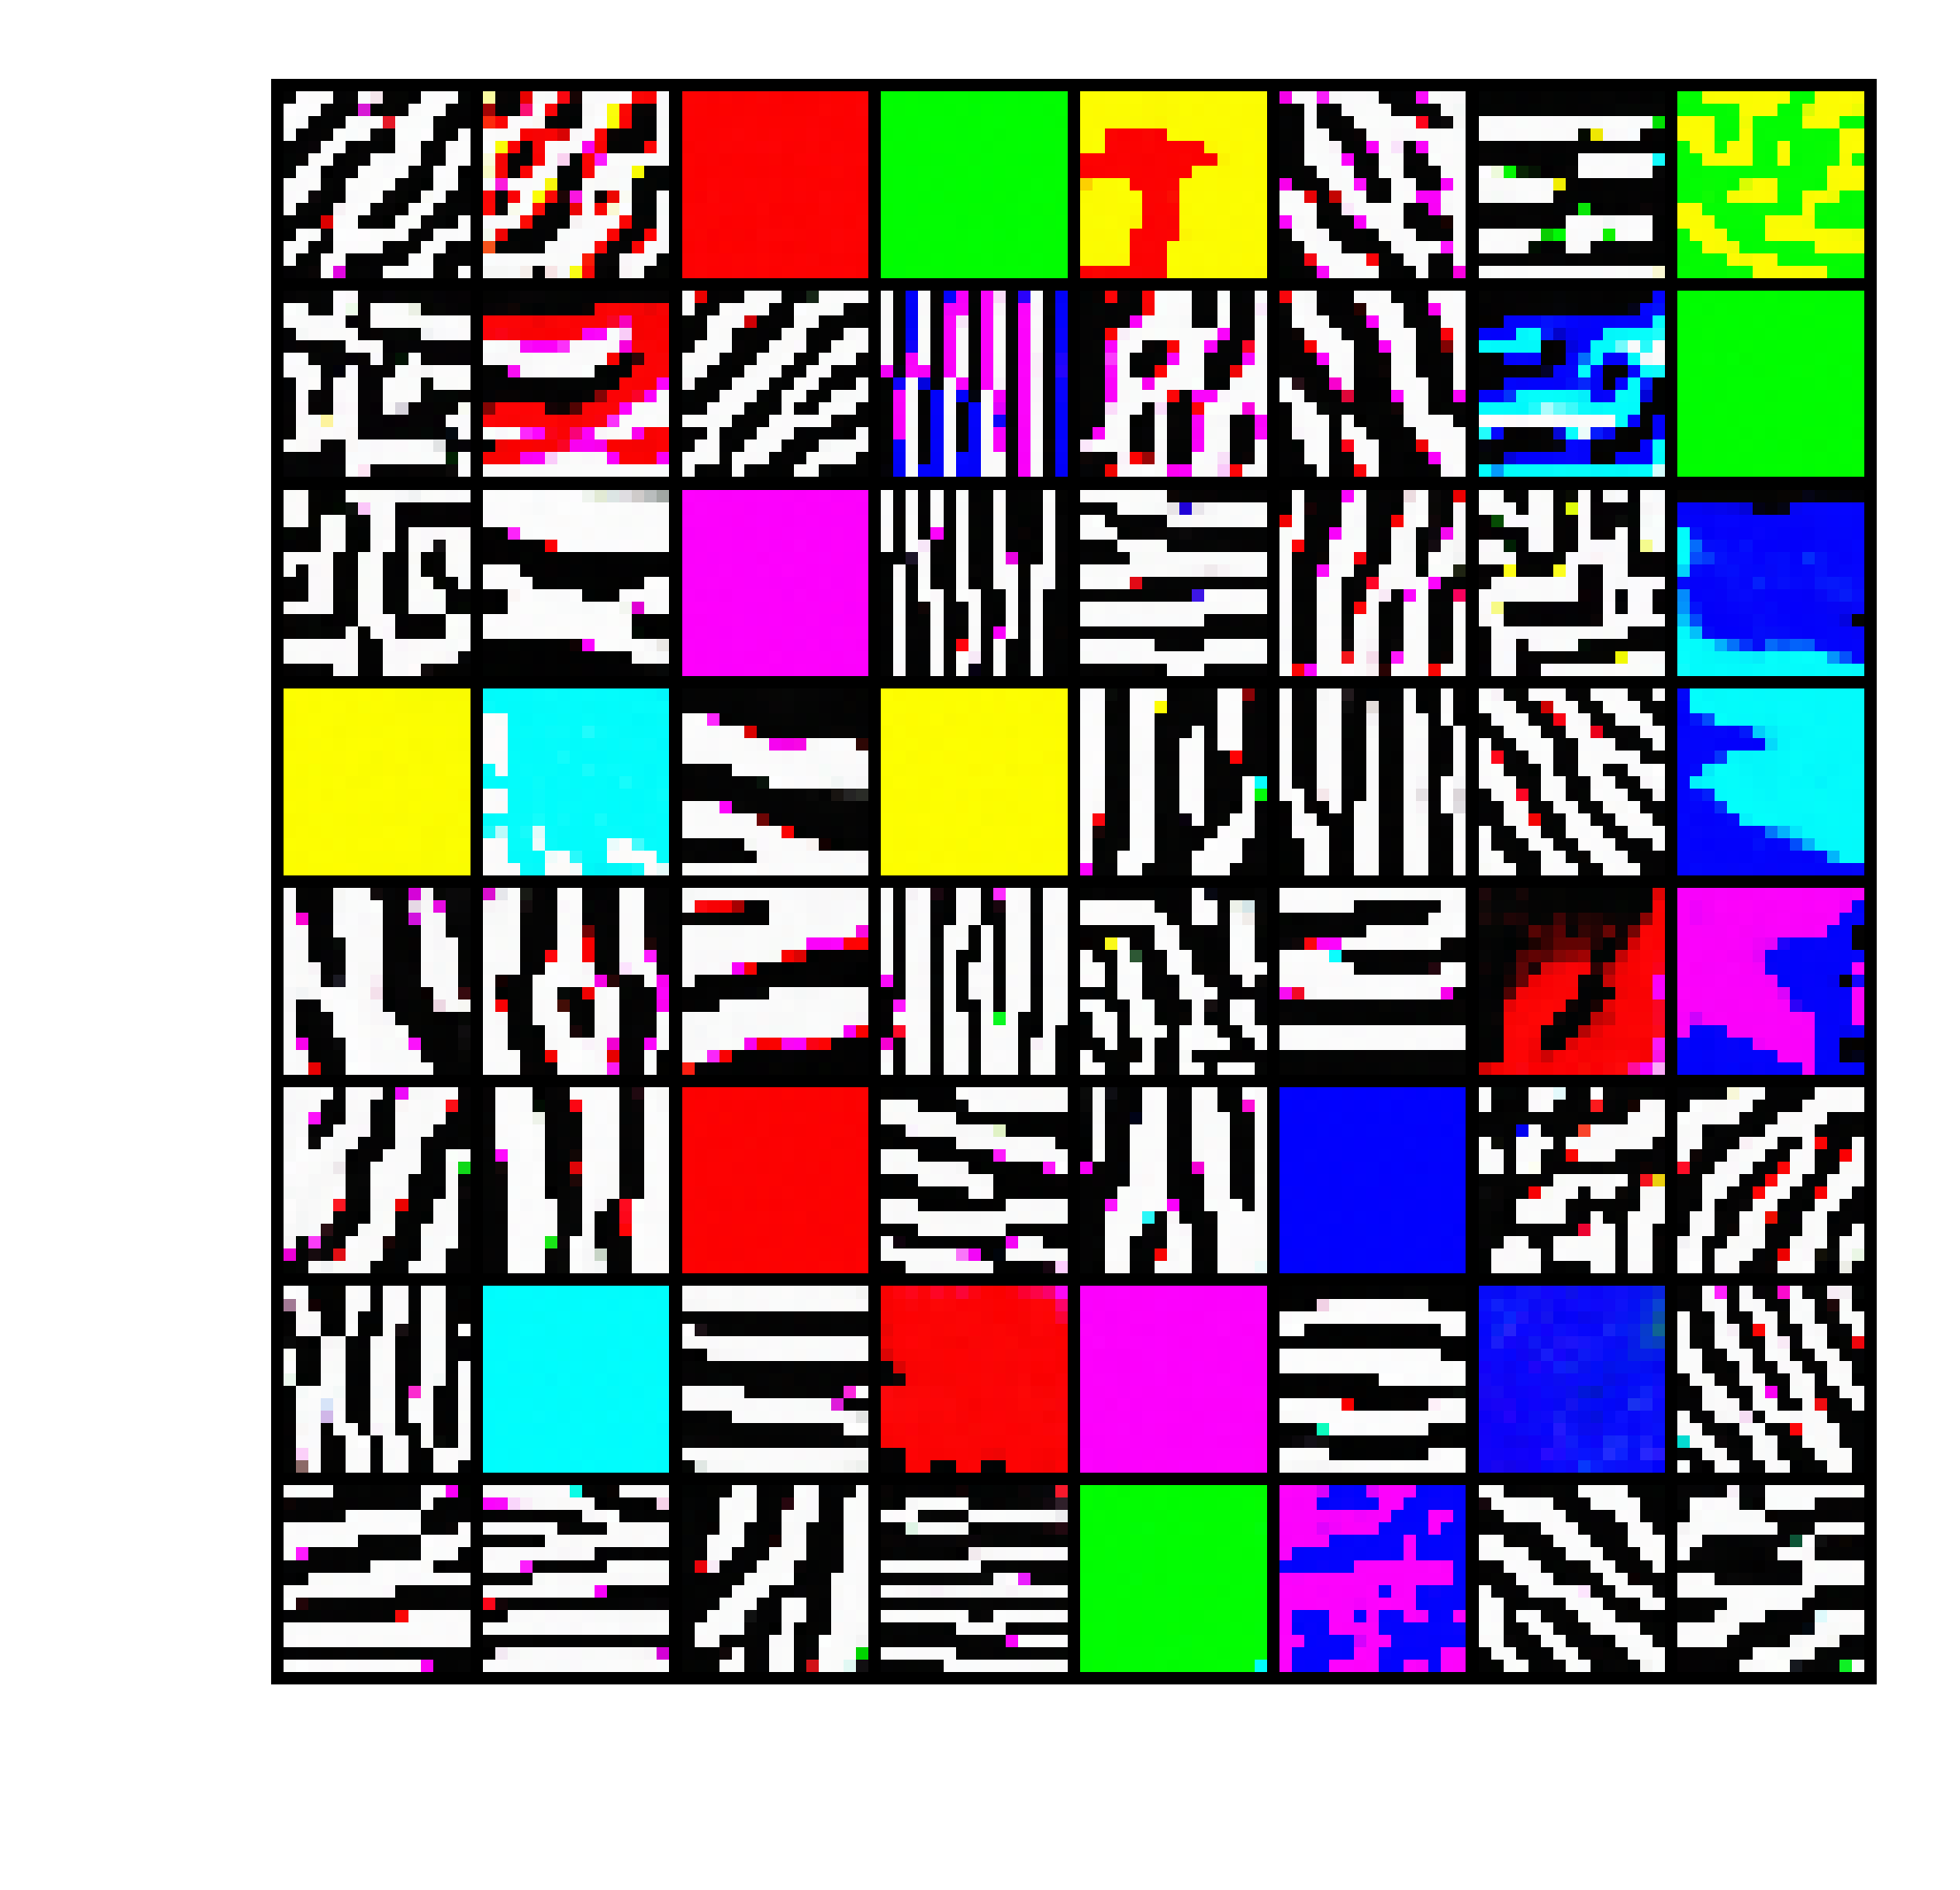

In [976]:
plt.imshow(display_map)
plt.axis('off')

# Layer 6 and on

In [961]:
tf.reset_default_graph()
max_depth = 10 # must be less than 30 where FC layers start
height, width = (15,15)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []

# filter shape `[filter_height, filter_width, in_channels, out_channels]`
this_W = np.array(f['layer_1/param_0']).copy()
this_W = np.rollaxis(this_W, 0, 4)
this_W = np.rollaxis(this_W, 0, 3)
act_W = tf.nn.conv2d(X_clipped, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W = tf.nn.relu(act_W + np.array(f['layer_1/param_1']))
model.append(relu_W)
    
for i,layer in enumerate(sorted_layer_names):
    if list(f[layer]) and i <= max_depth and i > 2:
        this_W = np.array(f[layer + '/param_0']).copy()
        this_W = np.rollaxis(this_W, 0, 4)
        this_W = np.rollaxis(this_W, 0, 3)
        act_W = tf.nn.conv2d(relu_W, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        relu_W = tf.nn.relu(act_W + np.array(f[layer + '/param_1']))
        model.append(relu_W)
        
        top_layer_reached = layer

for i in tqdm(range(64)):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,:,:,selected_unit])

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    grad_history = []
    activation_history = []
    regularization_history = []
    input_variance_history = []
    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    activity_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [03:52<00:00,  3.91s/it]


In [962]:
activity_maps.keys()

dict_keys(['layer_8', 'layer_3'])

(-0.5, 128.5, 128.5, -0.5)

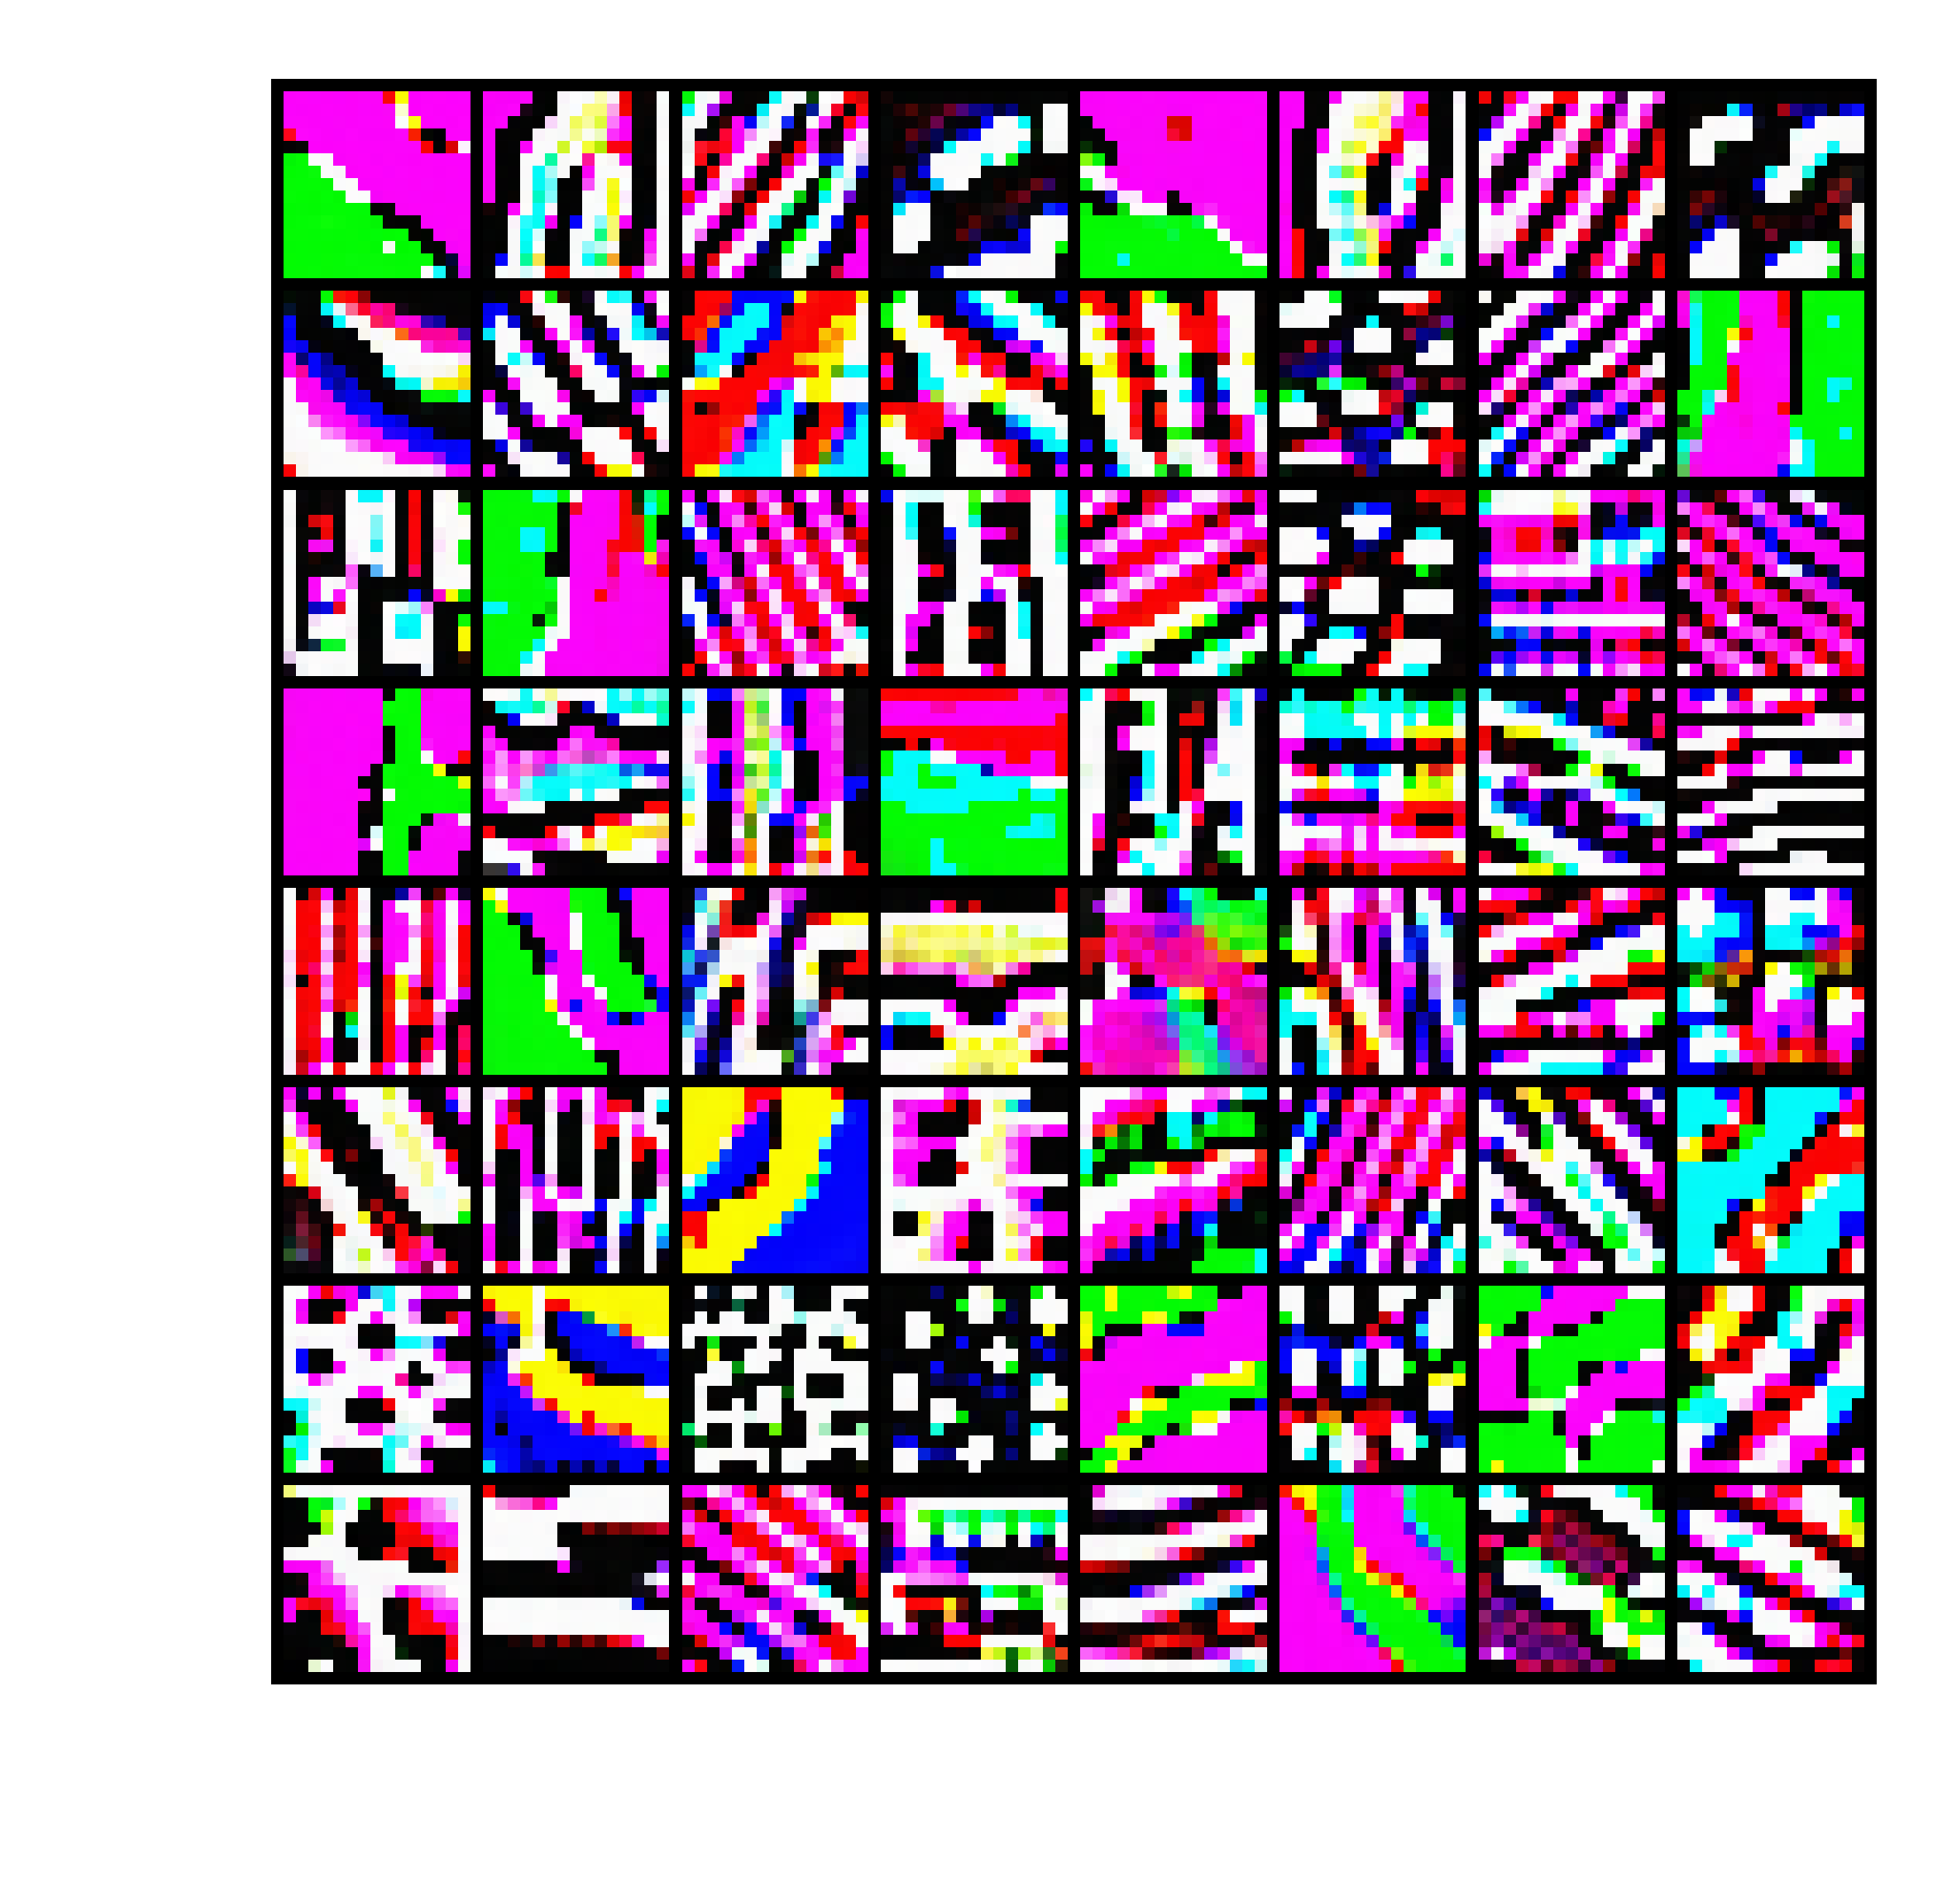

In [981]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(activity_maps['layer_8'][:64]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m
    
plt.imshow(display_map)
plt.axis('off')

# Layer 13

In [982]:
tf.reset_default_graph()
max_depth = 14 # must be less than 30 where FC layers start
height, width = (15,15)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []

# filter shape `[filter_height, filter_width, in_channels, out_channels]`
this_W = np.array(f['layer_1/param_0']).copy()
this_W = np.rollaxis(this_W, 0, 4)
this_W = np.rollaxis(this_W, 0, 3)
act_W = tf.nn.conv2d(X_clipped, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W = tf.nn.relu(act_W + np.array(f['layer_1/param_1']))
model.append(relu_W)
    
for i,layer in enumerate(sorted_layer_names):
    if list(f[layer]) and i <= max_depth and i > 2:
        this_W = np.array(f[layer + '/param_0']).copy()
        this_W = np.rollaxis(this_W, 0, 4)
        this_W = np.rollaxis(this_W, 0, 3)
        act_W = tf.nn.conv2d(relu_W, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        relu_W = tf.nn.relu(act_W + np.array(f[layer + '/param_1']))
        model.append(relu_W)
        
        top_layer_reached = layer

for i in tqdm(range(64)):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,:,:,selected_unit])

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    grad_history = []
    activation_history = []
    regularization_history = []
    input_variance_history = []
    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    activity_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [05:05<00:00,  5.08s/it]


In [983]:
activity_maps.keys()

dict_keys(['layer_8', 'layer_3', 'layer_13'])

(-0.5, 128.5, 128.5, -0.5)

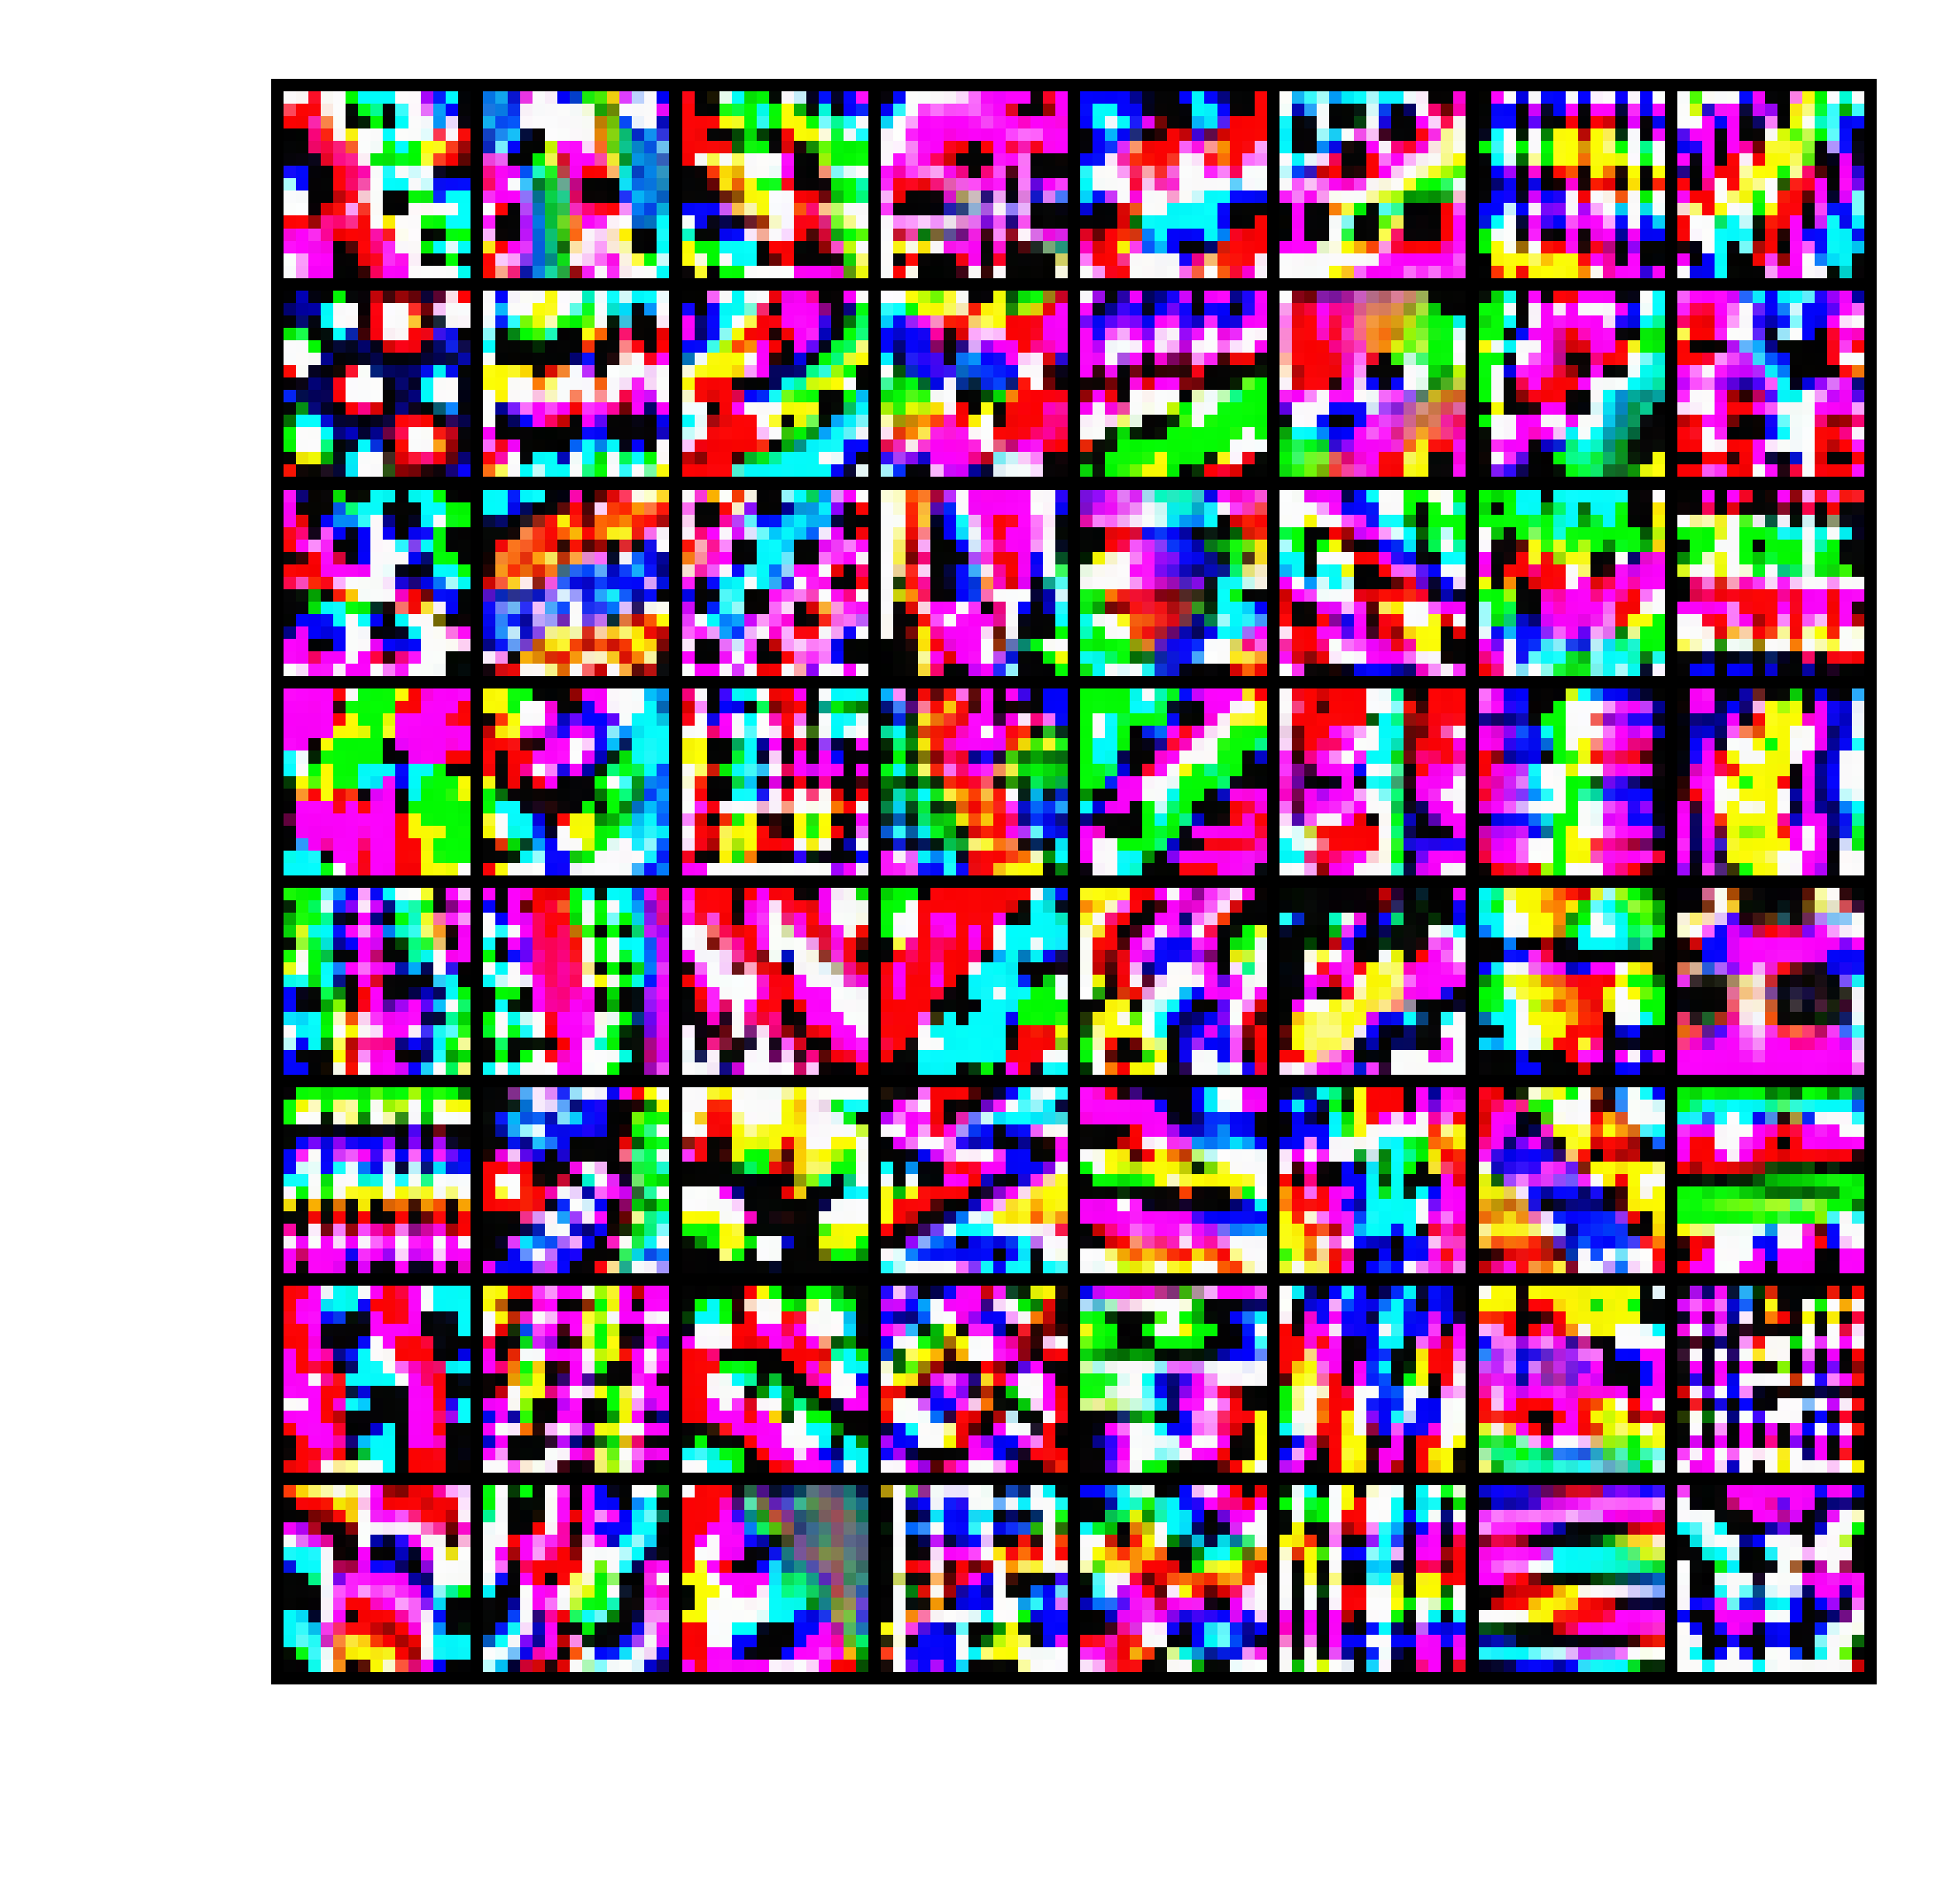

In [1013]:
height, width = (15,15)
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(activity_maps['layer_13'][:64]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m #[:,:,::-1]
    
plt.imshow(display_map)
plt.axis('off')

# Trying just activating a single unit - not a single filter type

In [1015]:
single_unit_activation_maps = collections.defaultdict(list)

In [1016]:
tf.reset_default_graph()
max_depth = 14 # must be less than 30 where FC layers start
height, width = (50,50)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []

# filter shape `[filter_height, filter_width, in_channels, out_channels]`
this_W = np.array(f['layer_1/param_0']).copy()
this_W = np.rollaxis(this_W, 0, 4)
this_W = np.rollaxis(this_W, 0, 3)
act_W = tf.nn.conv2d(X_clipped, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W = tf.nn.relu(act_W + np.array(f['layer_1/param_1']))
model.append(relu_W)
    
for i,layer in enumerate(sorted_layer_names):
    if list(f[layer]) and i <= max_depth and i > 2:
        this_W = np.array(f[layer + '/param_0']).copy()
        this_W = np.rollaxis(this_W, 0, 4)
        this_W = np.rollaxis(this_W, 0, 3)
        act_W = tf.nn.conv2d(relu_W, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        relu_W = tf.nn.relu(act_W + np.array(f[layer + '/param_1']))
        model.append(relu_W)
        
        top_layer_reached = layer

for i in tqdm(range(64)):
    selected_unit = i
    l2_reg = 1e-5
    desirable_activity = -tf.nn.l2_loss(model[-1][0,5:10,5:10,selected_unit])
    undesirable_activity = -tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    grad_history = []
    activation_history = []
    regularization_history = []
    input_variance_history = []
    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    single_unit_activation_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [07:26<00:00,  7.30s/it]


(-0.5, 408.5, 408.5, -0.5)

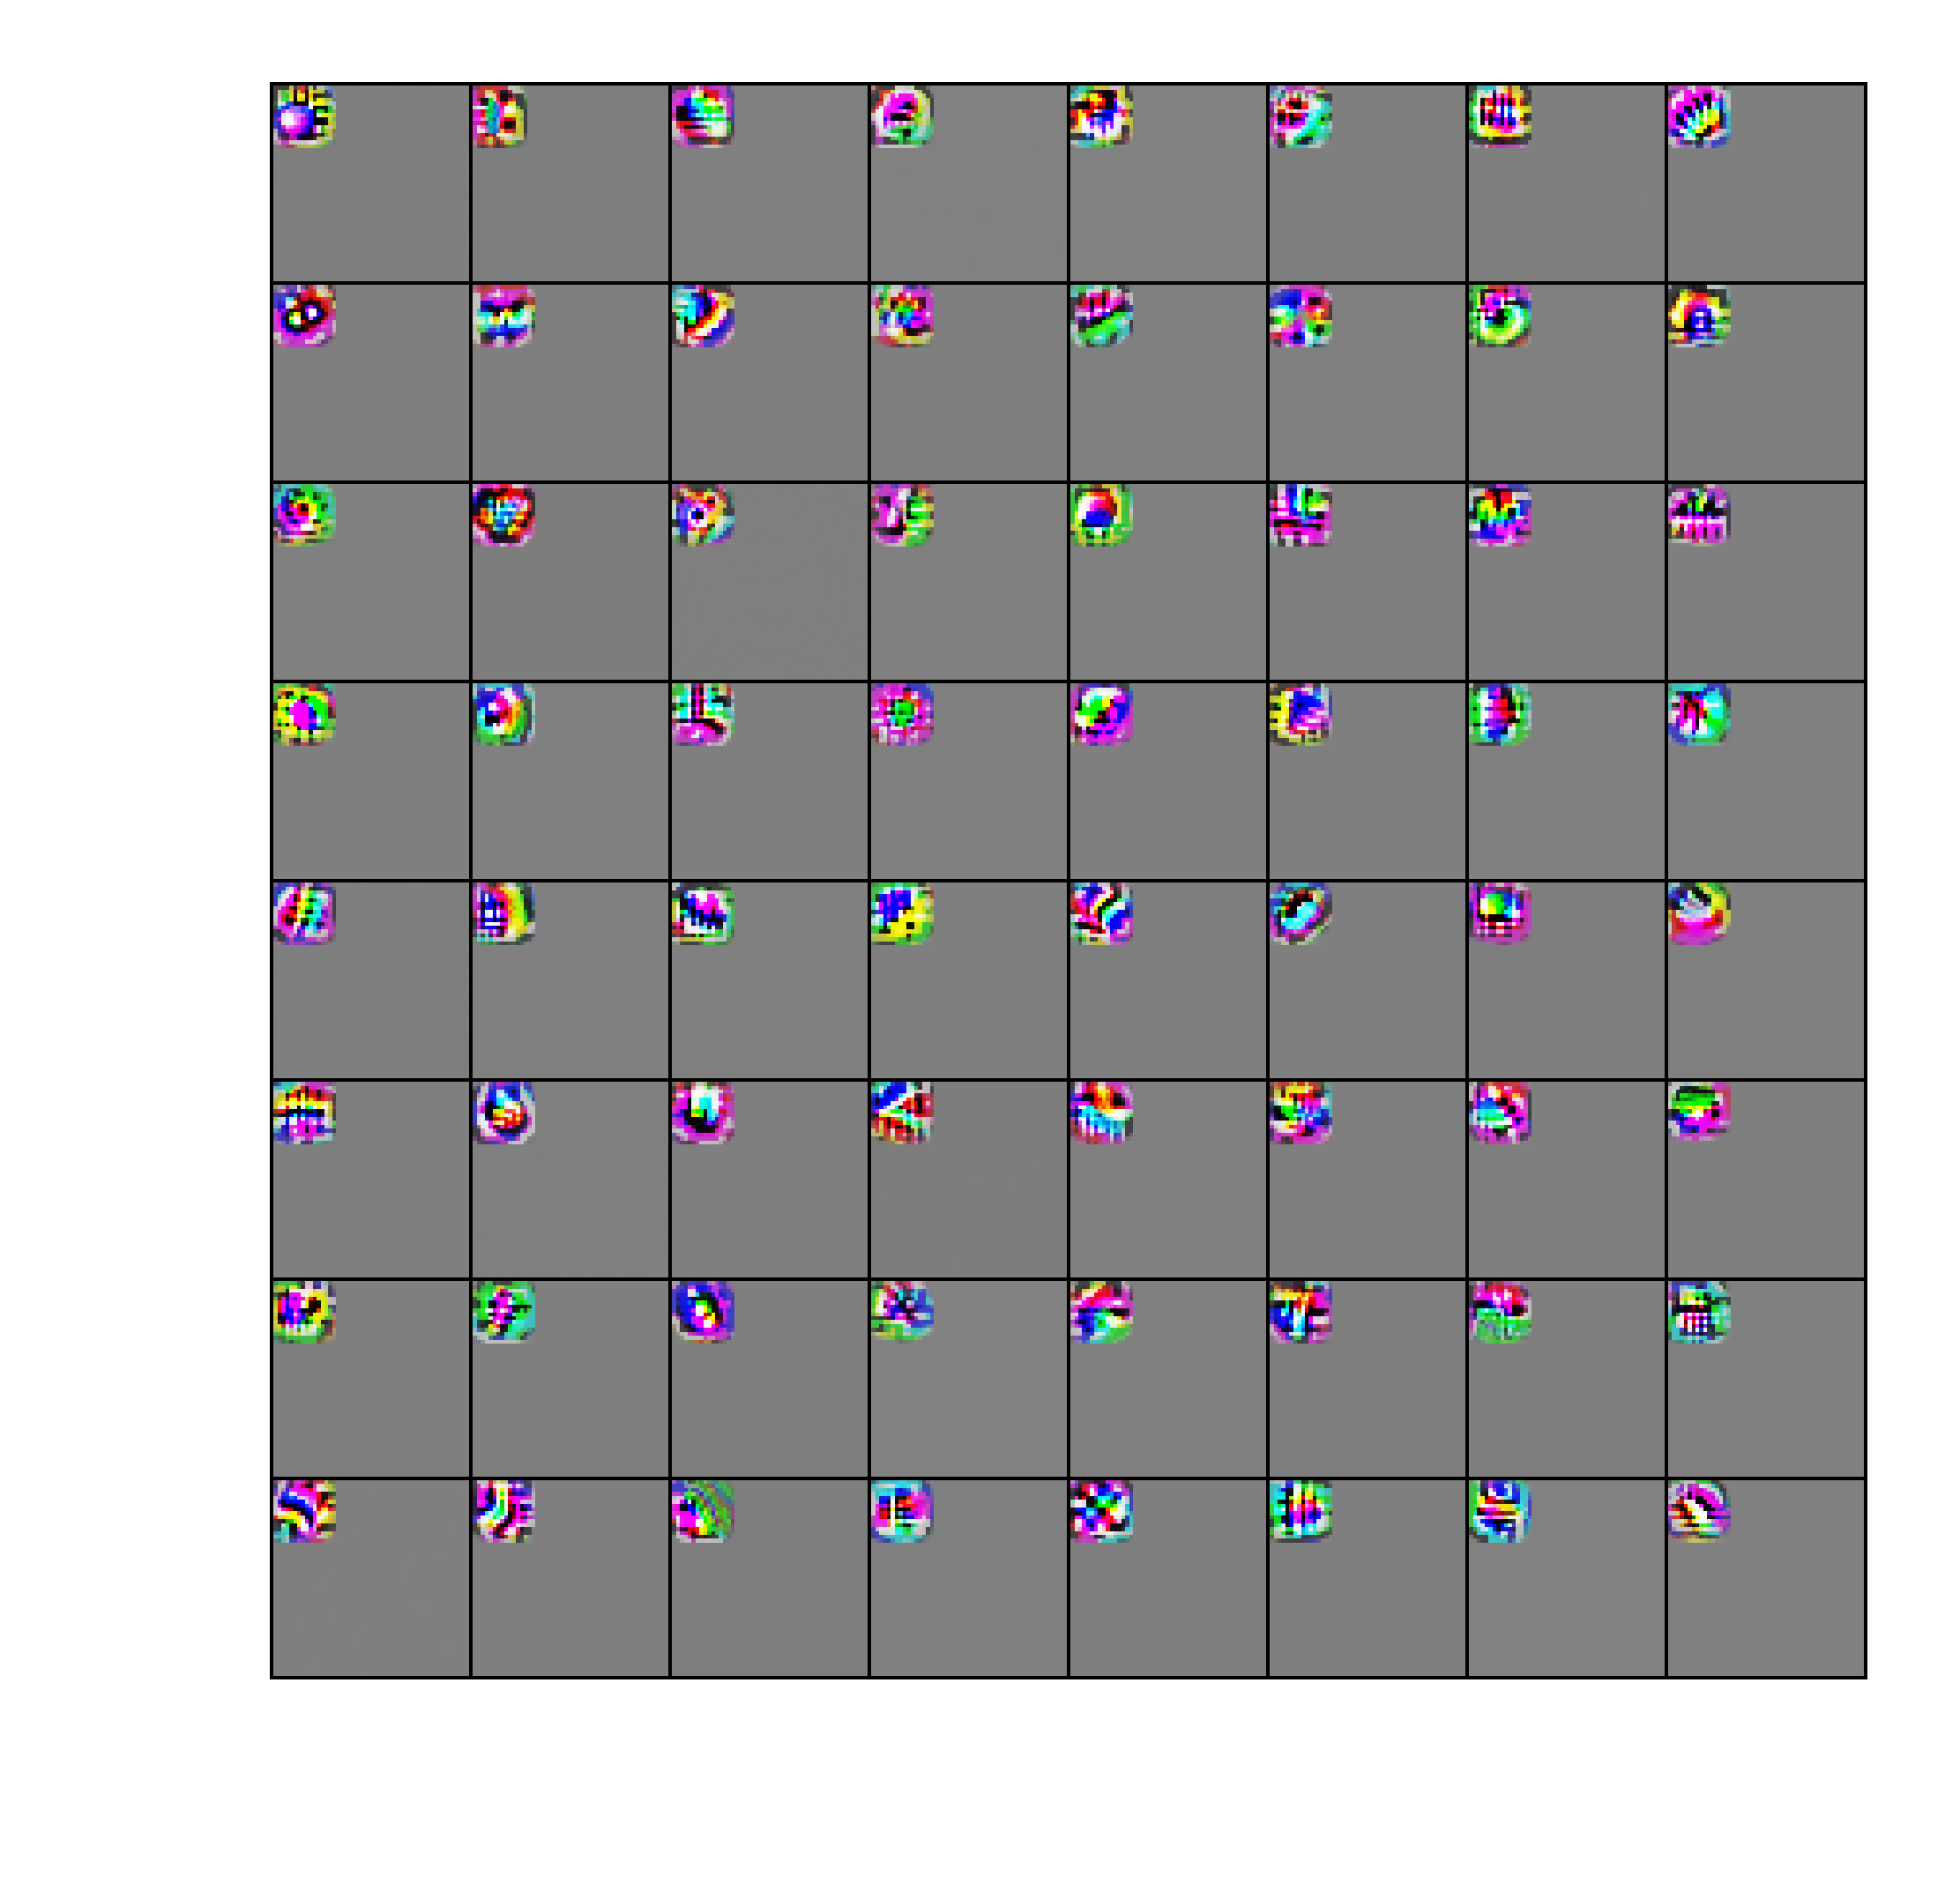

In [1059]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(single_unit_activation_maps['layer_13'][:64]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m[:,:,[2,1,0]]
    
plt.imshow(display_map)
plt.axis('off')

Ok we need to figure out this color channel ordering  
Use ILSVRC2012_val_00016666.JPEG

In [1029]:
from PIL import Image

In [1031]:
tmp = Image.open(os.path.expanduser('~/data/imagenet-data/raw-data/validation/ILSVRC2012_val_00016666.JPEG'), 'r')

In [1034]:
np.max(np.array(tmp))

255

In [1035]:
np.min(np.array(tmp))

0

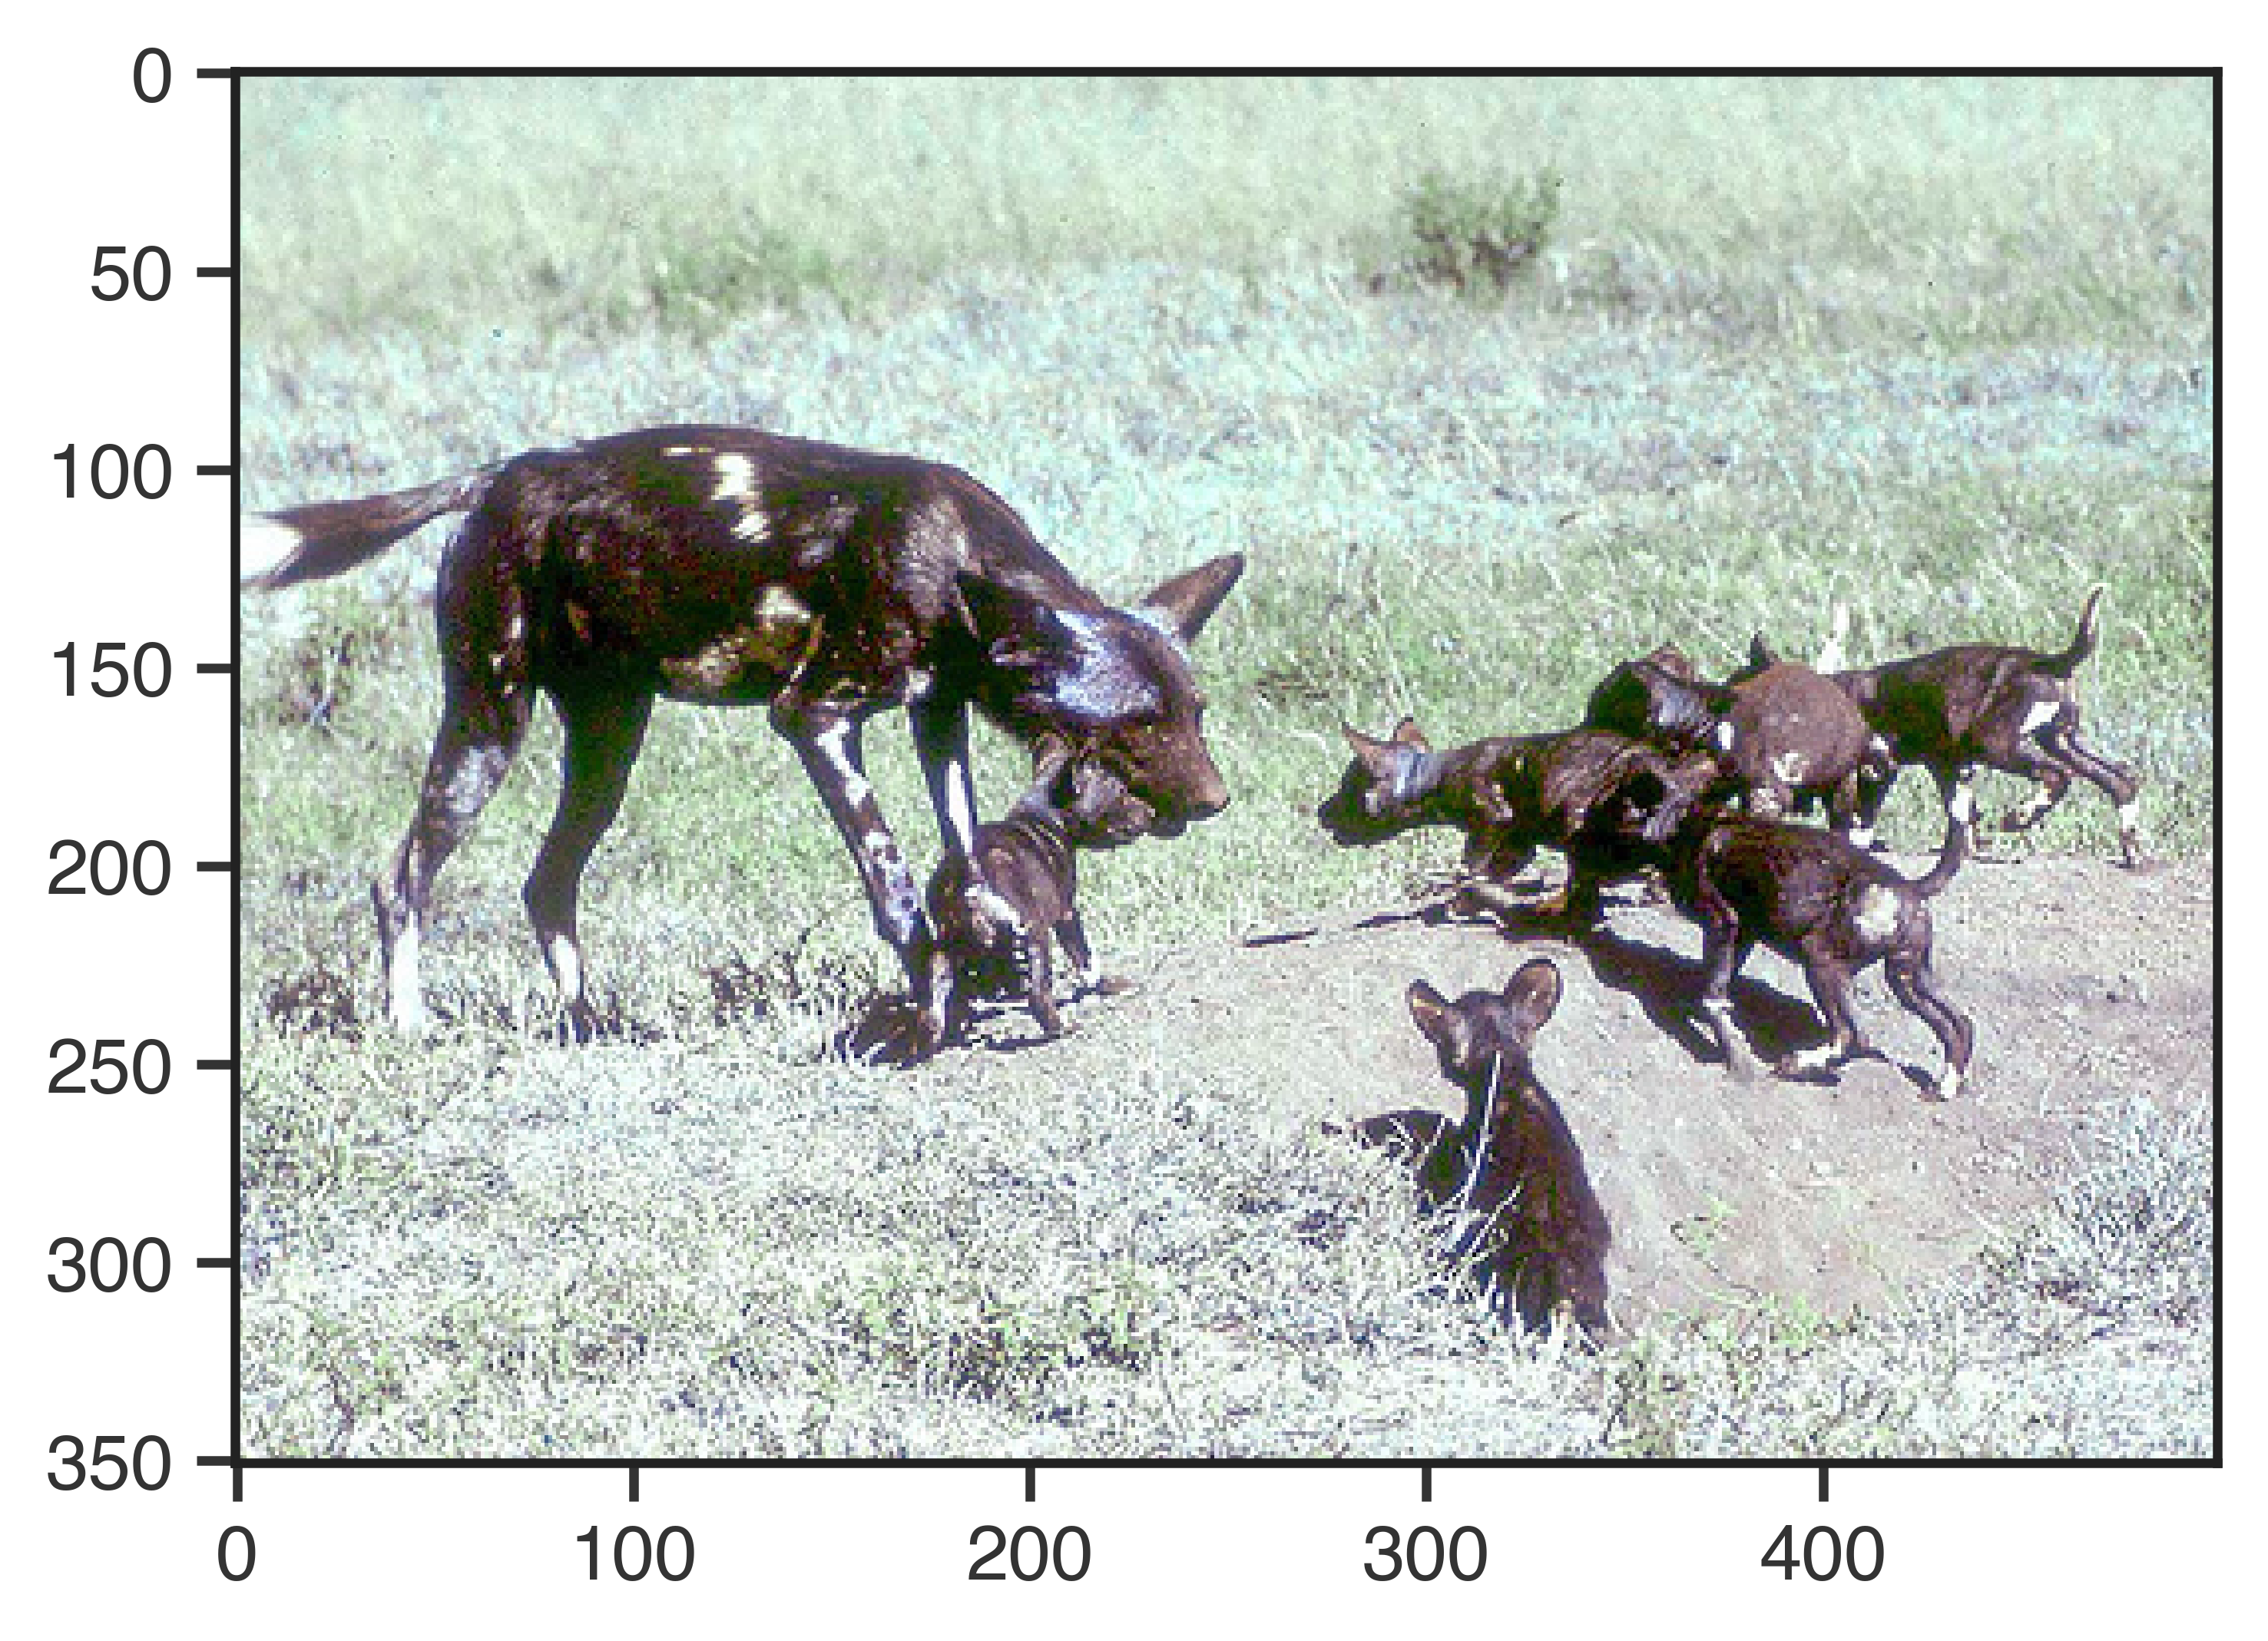

In [1039]:
plt.imshow(np.array(tmp)[:,:,::-1])

In [1041]:
tmp_image = display_map.copy()

In [1053]:
import colorsys

In [1067]:
new_image = np.zeros_like(tmp_image)
for y in range(new_image.shape[0]):
    for x in range(new_image.shape[1]):
        new_image[y,x] = colorsys.hsv_to_rgb(tmp_image[y,x,2], tmp_image[y,x,0], tmp_image[y,x,1])

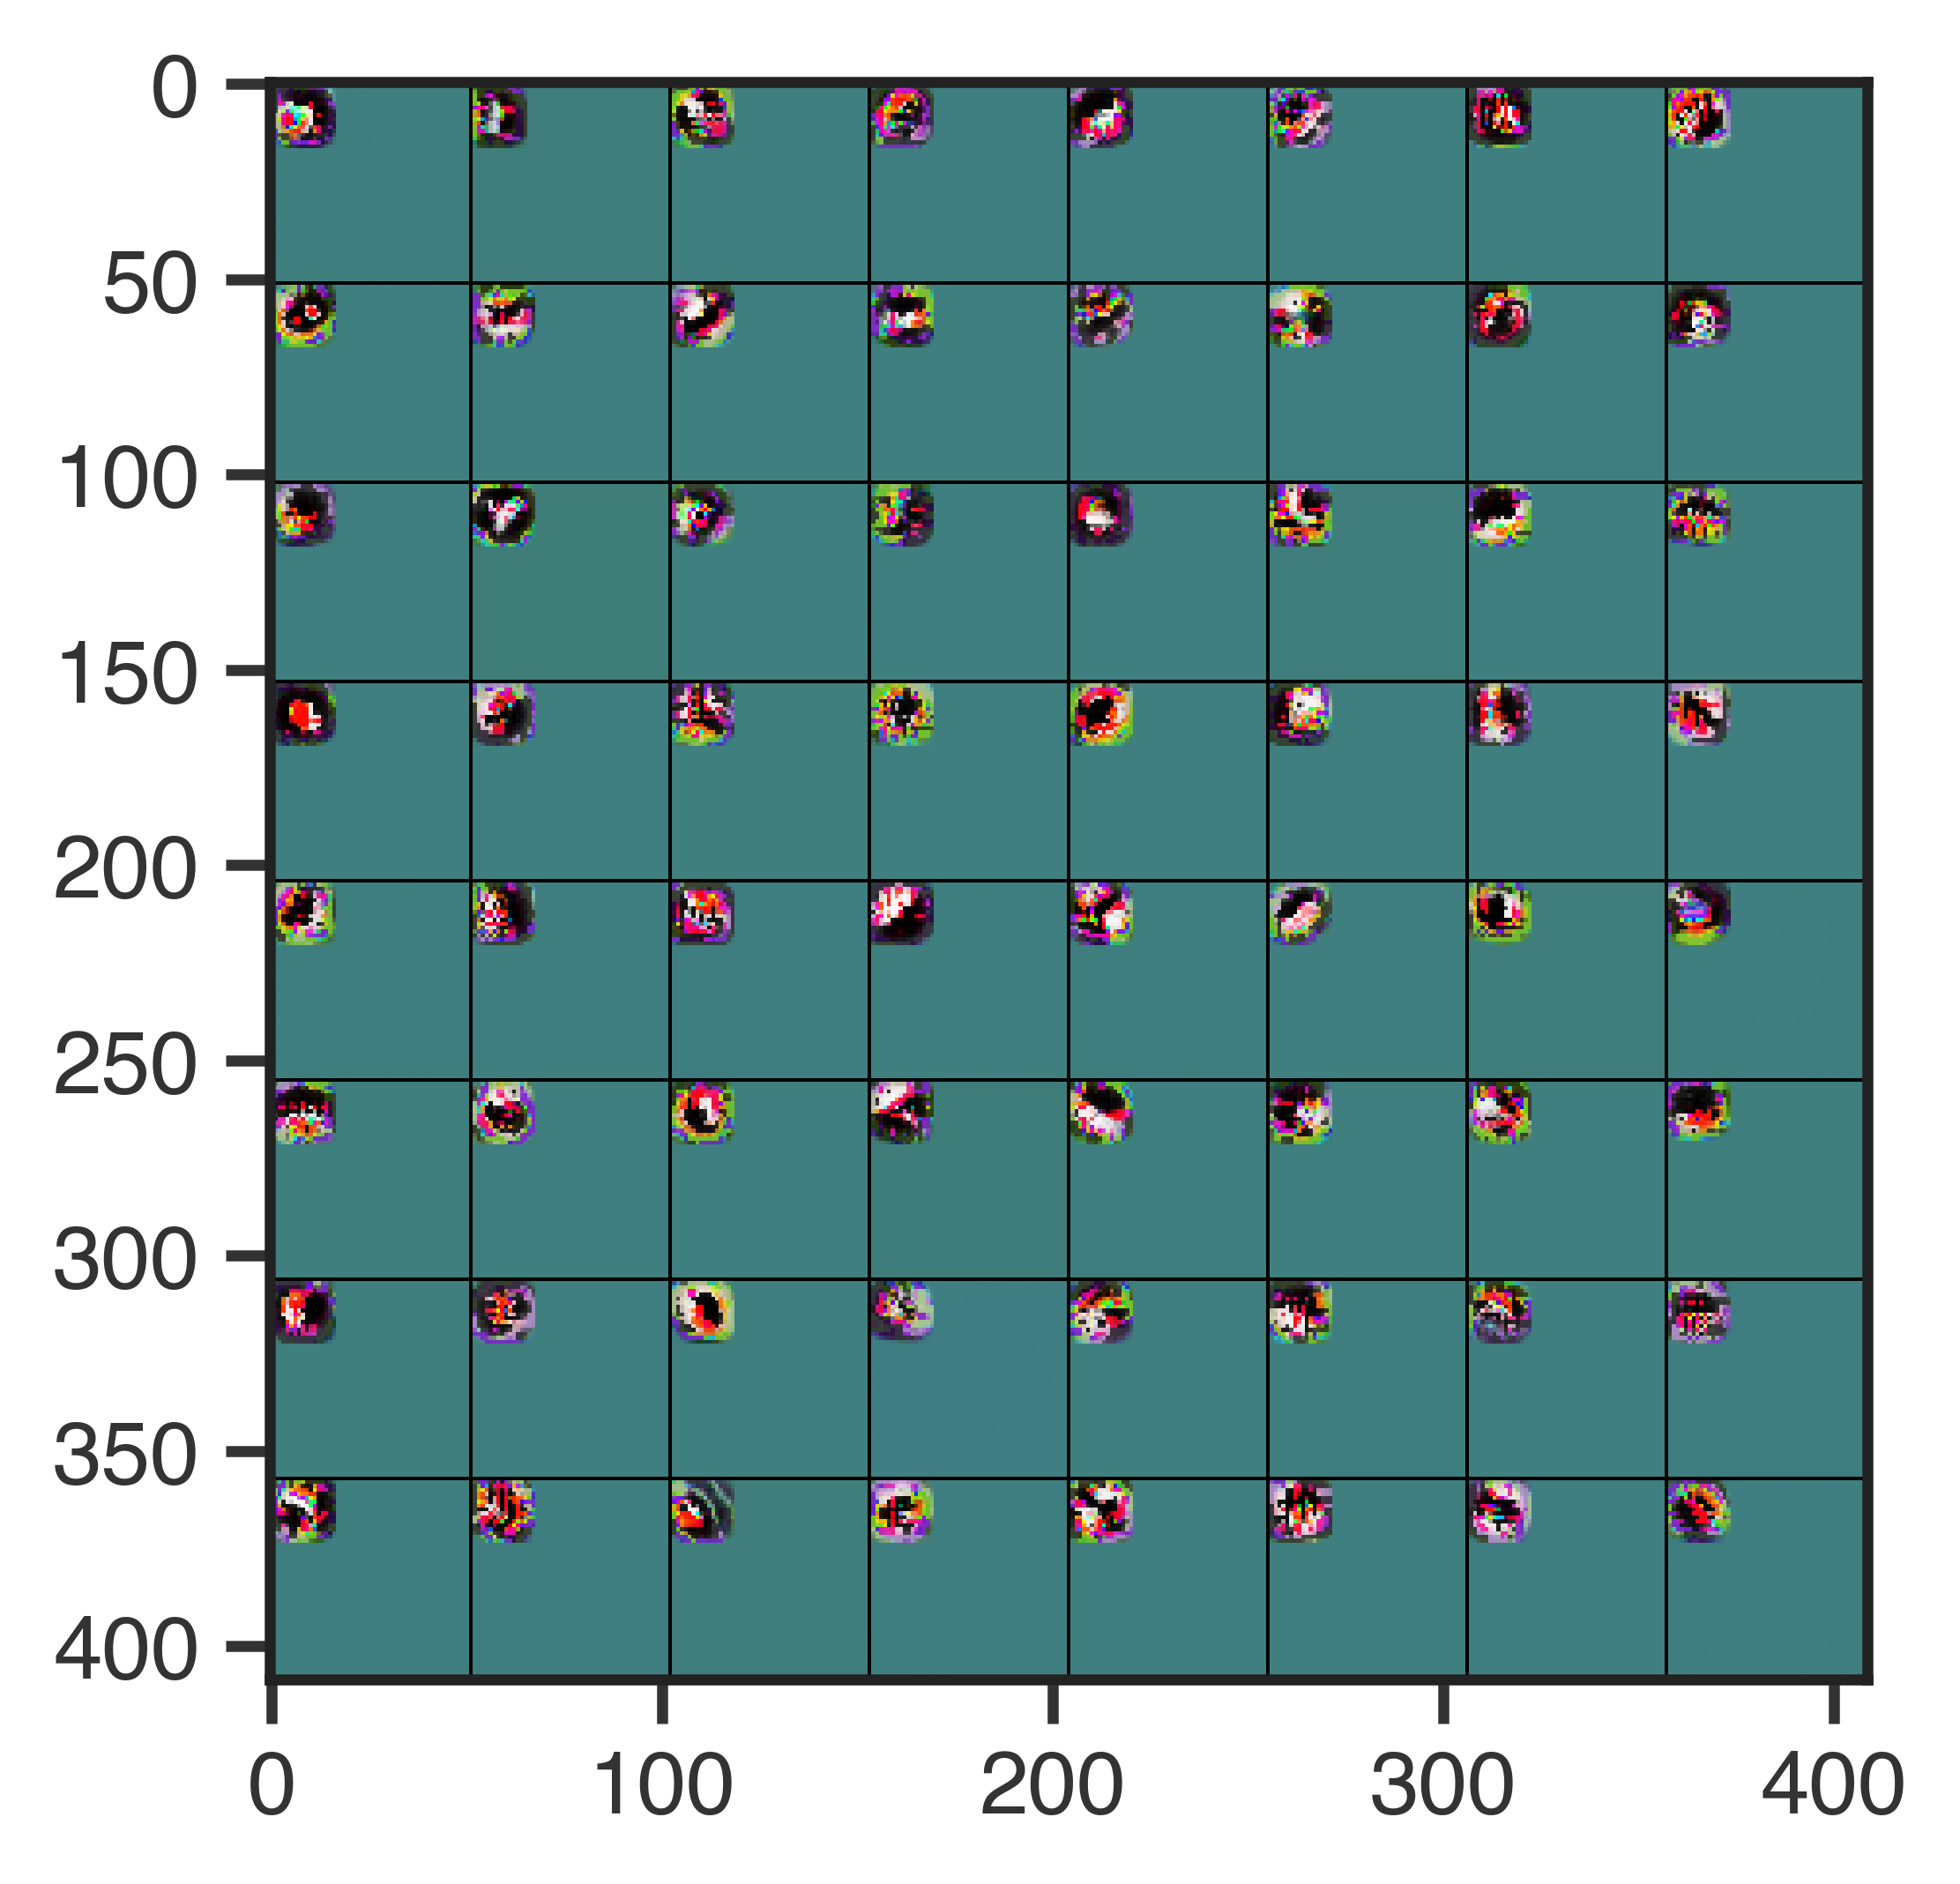

In [1068]:
plt.imshow(new_image)

In [1065]:
new_image = np.zeros_like(tmp_image)
for y in range(new_image.shape[0]):
    for x in range(new_image.shape[1]):
        new_image[y,x] = colorsys.yiq_to_rgb(tmp_image[y,x,2], tmp_image[y,x,1], tmp_image[y,x,0])

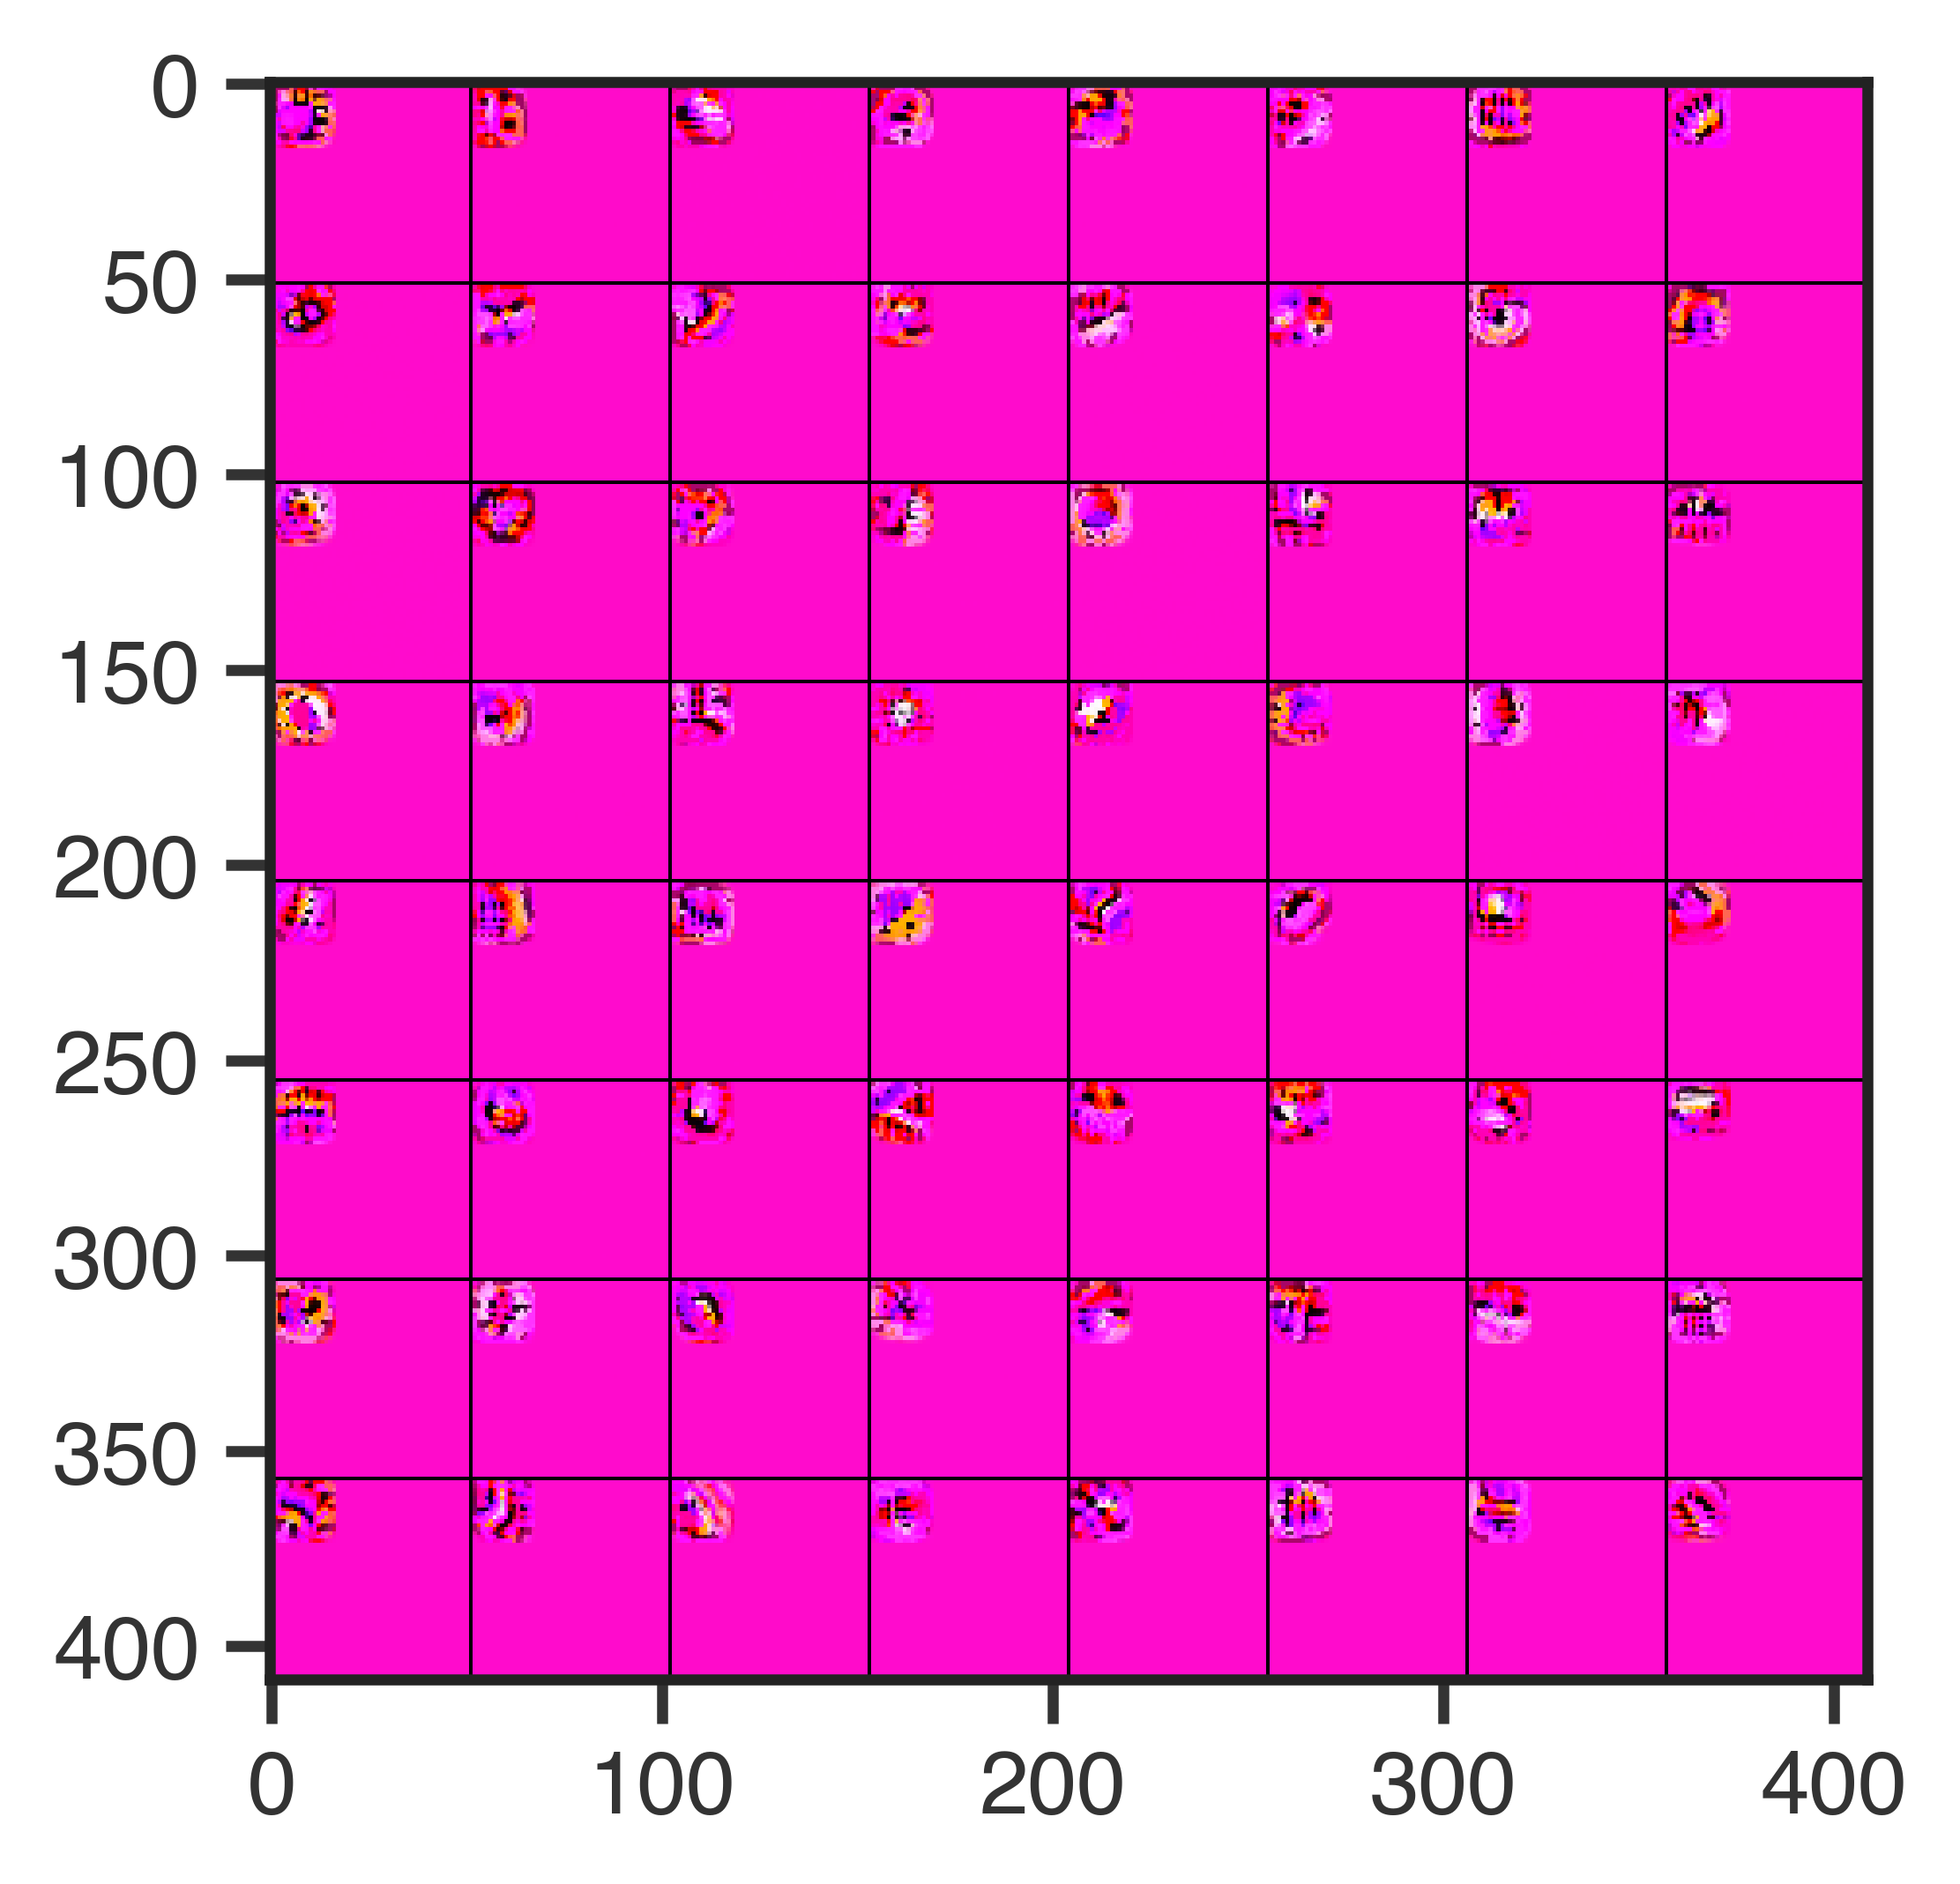

In [1066]:
plt.imshow(new_image)

# Verifying with legit RGB TF model

In [1070]:
weight_file = os.path.expanduser('~/data/vgg16-model/vgg16_weights.npz')
weights = np.load(weight_file)
weight_keys = sorted(weights.keys())

In [1071]:
weight_keys

['conv1_1_W',
 'conv1_1_b',
 'conv1_2_W',
 'conv1_2_b',
 'conv2_1_W',
 'conv2_1_b',
 'conv2_2_W',
 'conv2_2_b',
 'conv3_1_W',
 'conv3_1_b',
 'conv3_2_W',
 'conv3_2_b',
 'conv3_3_W',
 'conv3_3_b',
 'conv4_1_W',
 'conv4_1_b',
 'conv4_2_W',
 'conv4_2_b',
 'conv4_3_W',
 'conv4_3_b',
 'conv5_1_W',
 'conv5_1_b',
 'conv5_2_W',
 'conv5_2_b',
 'conv5_3_W',
 'conv5_3_b',
 'fc6_W',
 'fc6_b',
 'fc7_W',
 'fc7_b',
 'fc8_W',
 'fc8_b']

In [1074]:
weights[weight_keys[0]].shape

(3, 3, 3, 64)

In [1076]:
weights[weight_keys[0]][0,1,2,45]

0.2862331

In [1075]:
np.array(f['layer_1/param_0']).shape

(64, 3, 3, 3)

In [1084]:
np.array(f['layer_1/param_0'])[45,0,2,1]

0.2862331

In [1085]:
this_W = np.array(f['layer_1/param_0']).copy()
this_W = np.rollaxis(this_W, 0, 4)
this_W = np.rollaxis(this_W, 0, 3)
this_W.shape

(3, 3, 3, 64)

In [1091]:
this_W[2,1,0,45]

0.2862331

In [1115]:
ground_W1 = np.array(f['layer_1/param_0']).copy()

In [1116]:
ground_W1.shape

(64, 3, 3, 3)

In [1117]:
ground_W1 = np.swapaxes(ground_W1, 1, 3)
ground_W1 = np.swapaxes(ground_W1, 0, 3)
ground_W1.shape

(3, 3, 3, 64)

In [1118]:
ground_W1[0,1,2,45]

0.2862331

# Okay, now we know what to do to be in the right space

### W3

In [1120]:
np.array(f['layer_3/param_0']).copy().shape

(64, 64, 3, 3)

In [1122]:
weights[weight_keys[2]].shape

(3, 3, 64, 64)

In [1125]:
weights[weight_keys[2]][0,2,37,54]

-0.027442282

In [1123]:
W3 = np.array(f['layer_3/param_0']).copy()
W3 = np.swapaxes(W3, 1, 3)
W3 = np.swapaxes(W3, 0, 3)

In [1124]:
W3.shape

(64, 3, 3, 64)

In [1126]:
W3[37,0,2,54]

-0.027442282

In [1127]:
W3 = np.array(f['layer_3/param_0']).copy()
W3 = np.swapaxes(W3, 1, 2)
W3 = np.swapaxes(W3, 0, 3)

In [1128]:
W3.shape

(3, 3, 64, 64)

In [1129]:
W3[0,2,37,54]

-0.027442282

In [1130]:
W1 = np.array(f['layer_1/param_0']).copy()
W1 = np.swapaxes(W1, 1, 2)
W1 = np.swapaxes(W1, 0, 3)

In [1131]:
W1.shape

(3, 3, 3, 64)

In [1132]:
W1[0,1,2,45]

0.36411214

In [1133]:
weights[weight_keys[4]].shape

(3, 3, 64, 128)

In [1136]:
W6 = np.array(f['layer_6/param_0']).copy()
W6 = np.swapaxes(W6, 1, 2)
W6 = np.swapaxes(W6, 0, 3)

In [1137]:
W6.shape

(3, 3, 64, 128)

In [1138]:
weights[weight_keys[4]][2,0,54, 97]

-0.0015039152

In [1139]:
W6[2,0,54, 97]

-0.0015039152

#### This is all done messed up. It seems like caffe's first layer channel ordering is different from later layers

In [1141]:
activity_maps = collections.defaultdict(list)
for i in tqdm(range(64)):
    tf.reset_default_graph()
    height, width = (15,15)
    with tf.variable_scope('input'):
        # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
        X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))

    # filter shape `[filter_height, filter_width, in_channels, out_channels]`
    W1 = np.array(f['layer_1/param_0']).copy()
    W1 = np.rollaxis(W1, 0, 4)
    W1 = np.rollaxis(W1, 0, 3)
    X_clipped = tf.clip_by_value(X, -128., 128.)
    W1x = tf.nn.conv2d(X_clipped, W1, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
    relu_W1x = tf.nn.relu(W1x + np.array(f['layer_1/param_1']))
    
    W3 = np.array(f['layer_3/param_0']).copy()
    W3 = np.swapaxes(W3, 1, 2)
    W3 = np.swapaxes(W3, 0, 3)
    W3x = tf.nn.conv2d(relu_W1x, W3, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
    relu_W3x = tf.nn.relu(W3x + np.array(f['layer_3/param_1']))
    
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(relu_W3x[0,:,:,selected_unit])

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    grad_history = []
    activation_history = []
    regularization_history = []
    input_variance_history = []
    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    activity_maps['layer_3'].append(rescaled_img)

100%|██████████| 64/64 [02:25<00:00,  2.34s/it]


(-0.5, 128.5, 128.5, -0.5)

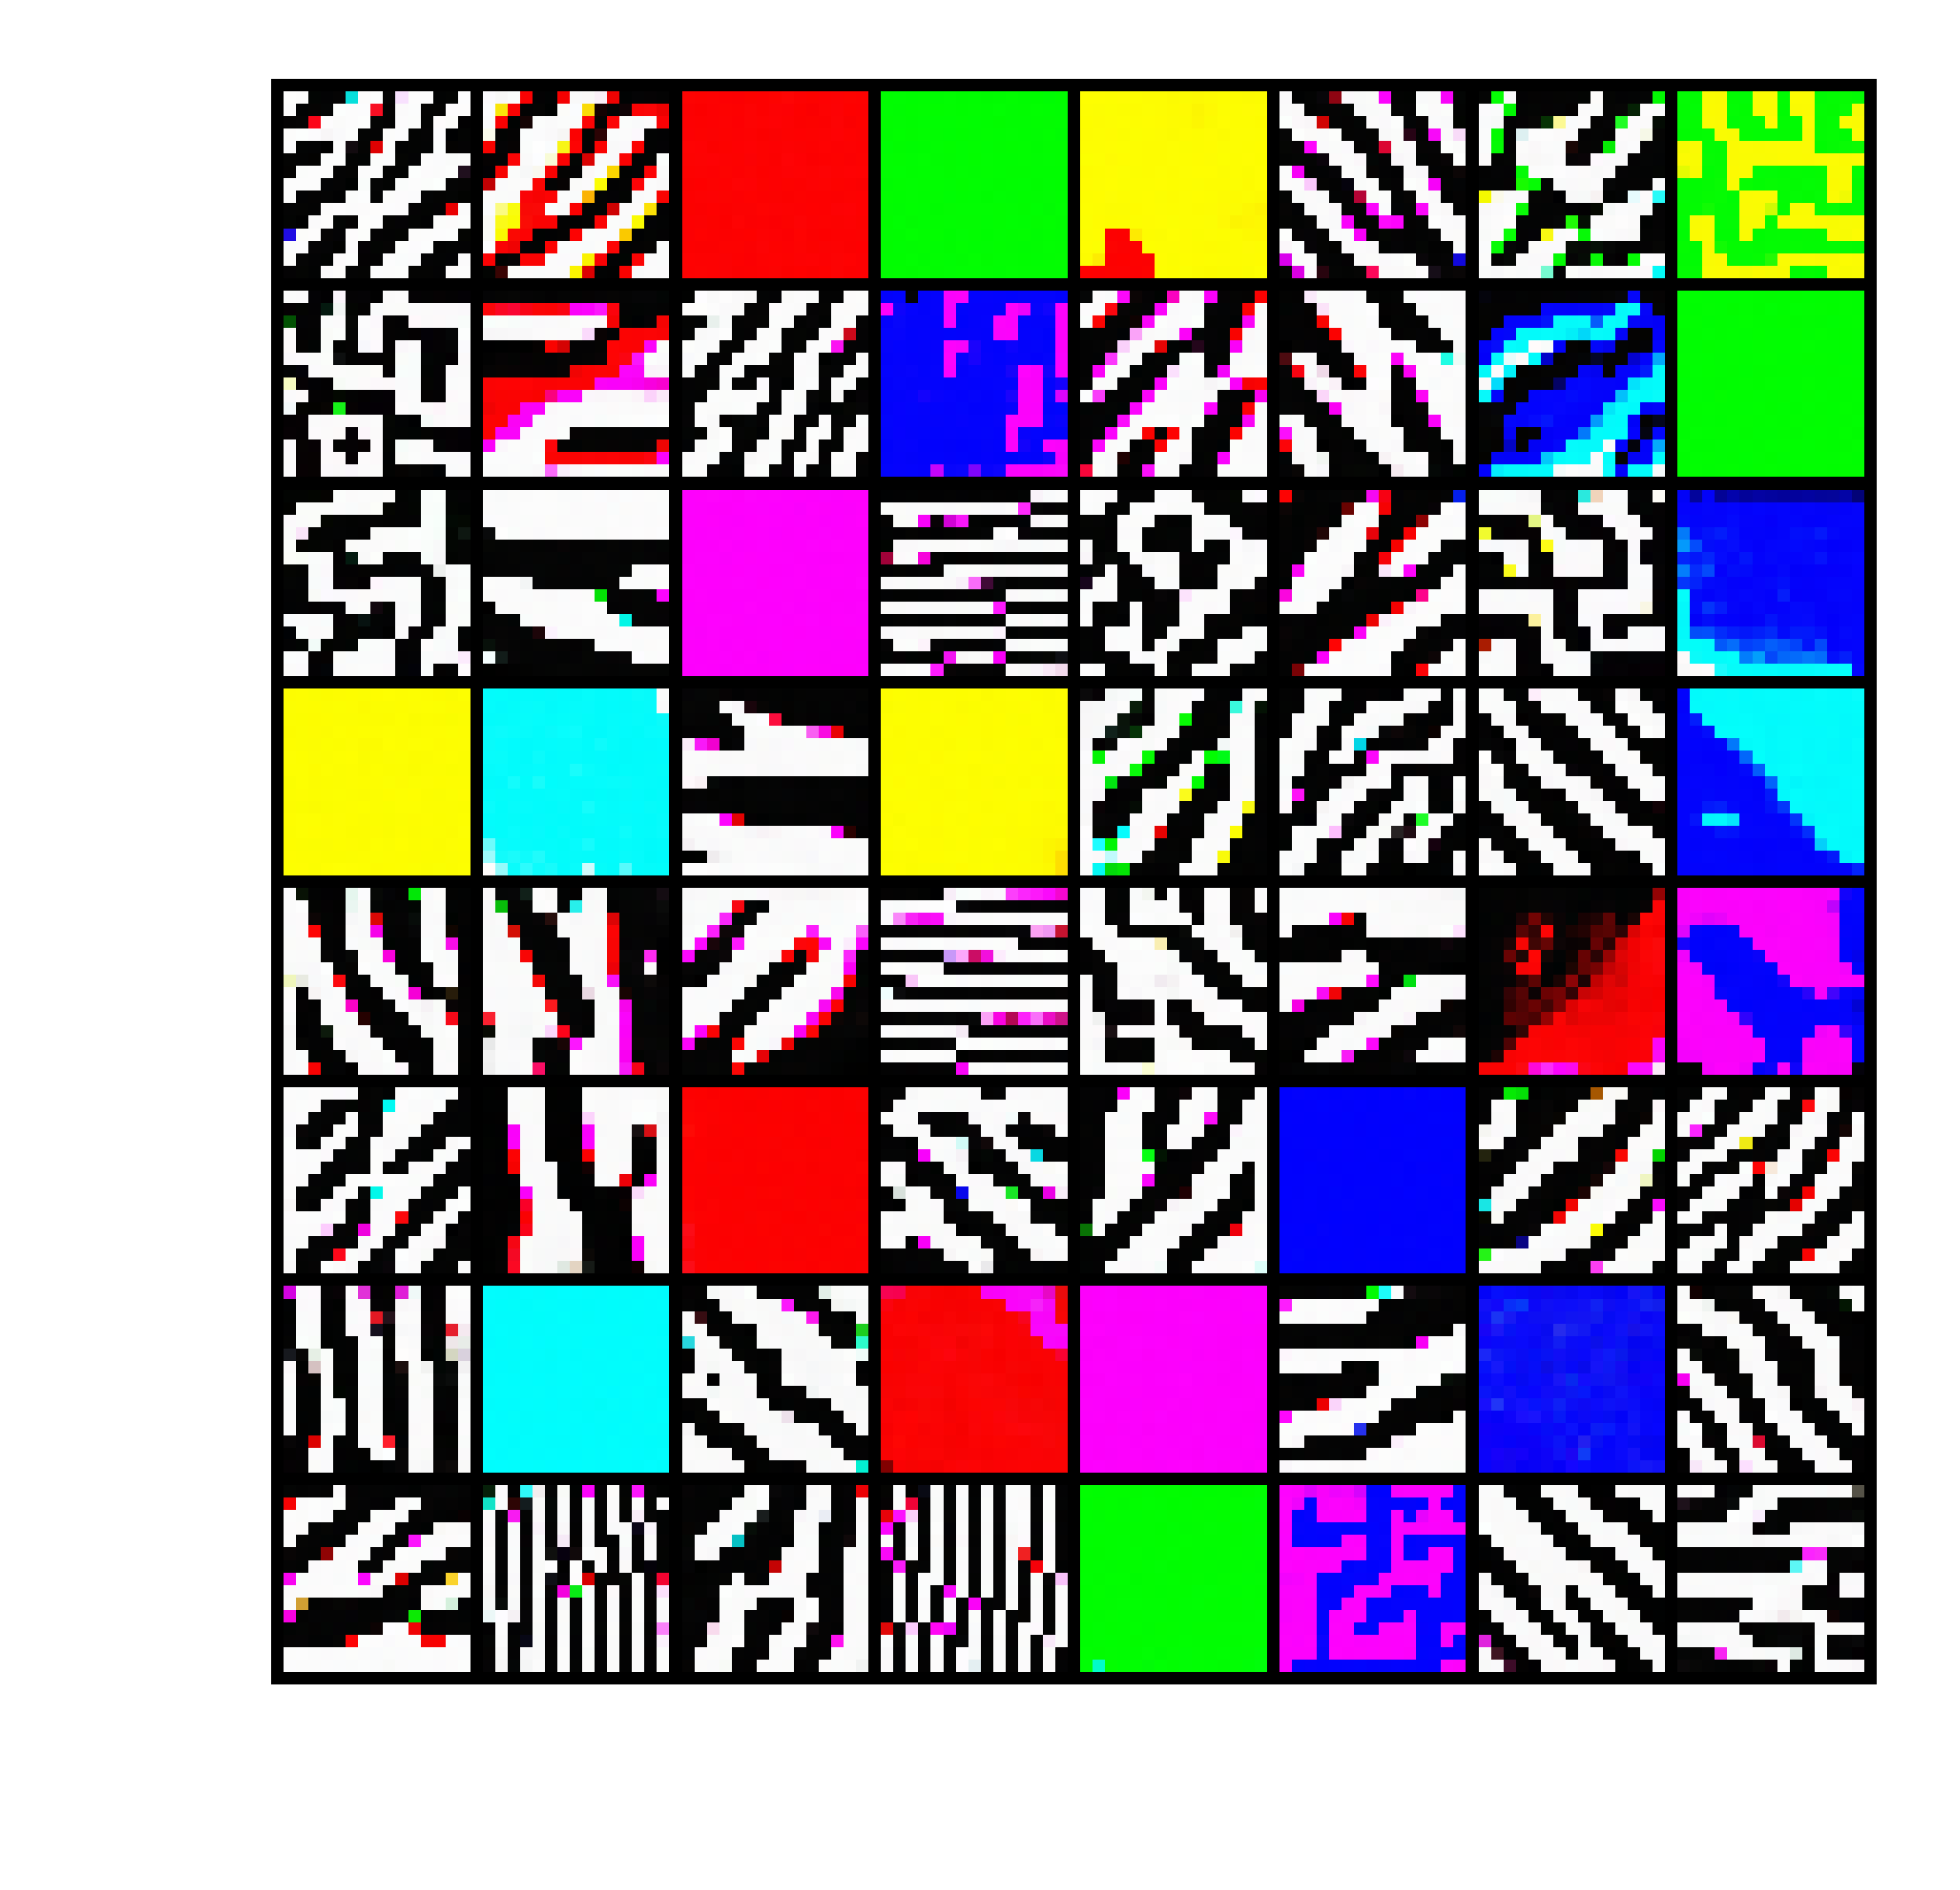

In [1142]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(activity_maps['layer_3']):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m
    
plt.imshow(display_map)
plt.axis('off')

In [1143]:
tf.reset_default_graph()
max_depth = 14 # must be less than 30 where FC layers start
height, width = (30,30)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []

# filter shape `[filter_height, filter_width, in_channels, out_channels]`
this_W = np.array(f['layer_1/param_0']).copy()
this_W = np.rollaxis(this_W, 0, 4)
this_W = np.rollaxis(this_W, 0, 3)
act_W = tf.nn.conv2d(X_clipped, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W = tf.nn.relu(act_W + np.array(f['layer_1/param_1']))
model.append(relu_W)
    
for i,layer in enumerate(sorted_layer_names):
    if list(f[layer]) and i <= max_depth and i > 2:
        this_W = np.array(f[layer + '/param_0']).copy()
        this_W = np.swapaxes(this_W, 1, 2)
        this_W = np.swapaxes(this_W, 0, 3)
        act_W = tf.nn.conv2d(relu_W, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        relu_W = tf.nn.relu(act_W + np.array(f[layer + '/param_1']))
        model.append(relu_W)
        
        top_layer_reached = layer

for i in tqdm(range(64)):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,12:18,12:18,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    grad_history = []
    activation_history = []
    regularization_history = []
    input_variance_history = []
    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    single_unit_activation_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [05:16<00:00,  5.30s/it]


In [1145]:
single_unit_activation_maps.keys()

dict_keys(['layer_13'])

In [1178]:
x,y = np.meshgrid(np.linspace(-2,2,10), np.linspace(-2,2,10))
blur = multivariate_normal(mean=np.zeros((2,)), cov=np.eye(2))
this_blur = blur.pdf(np.stack([x.flat,y.flat]).T)
this_blur = this_blur.reshape(*x.shape)

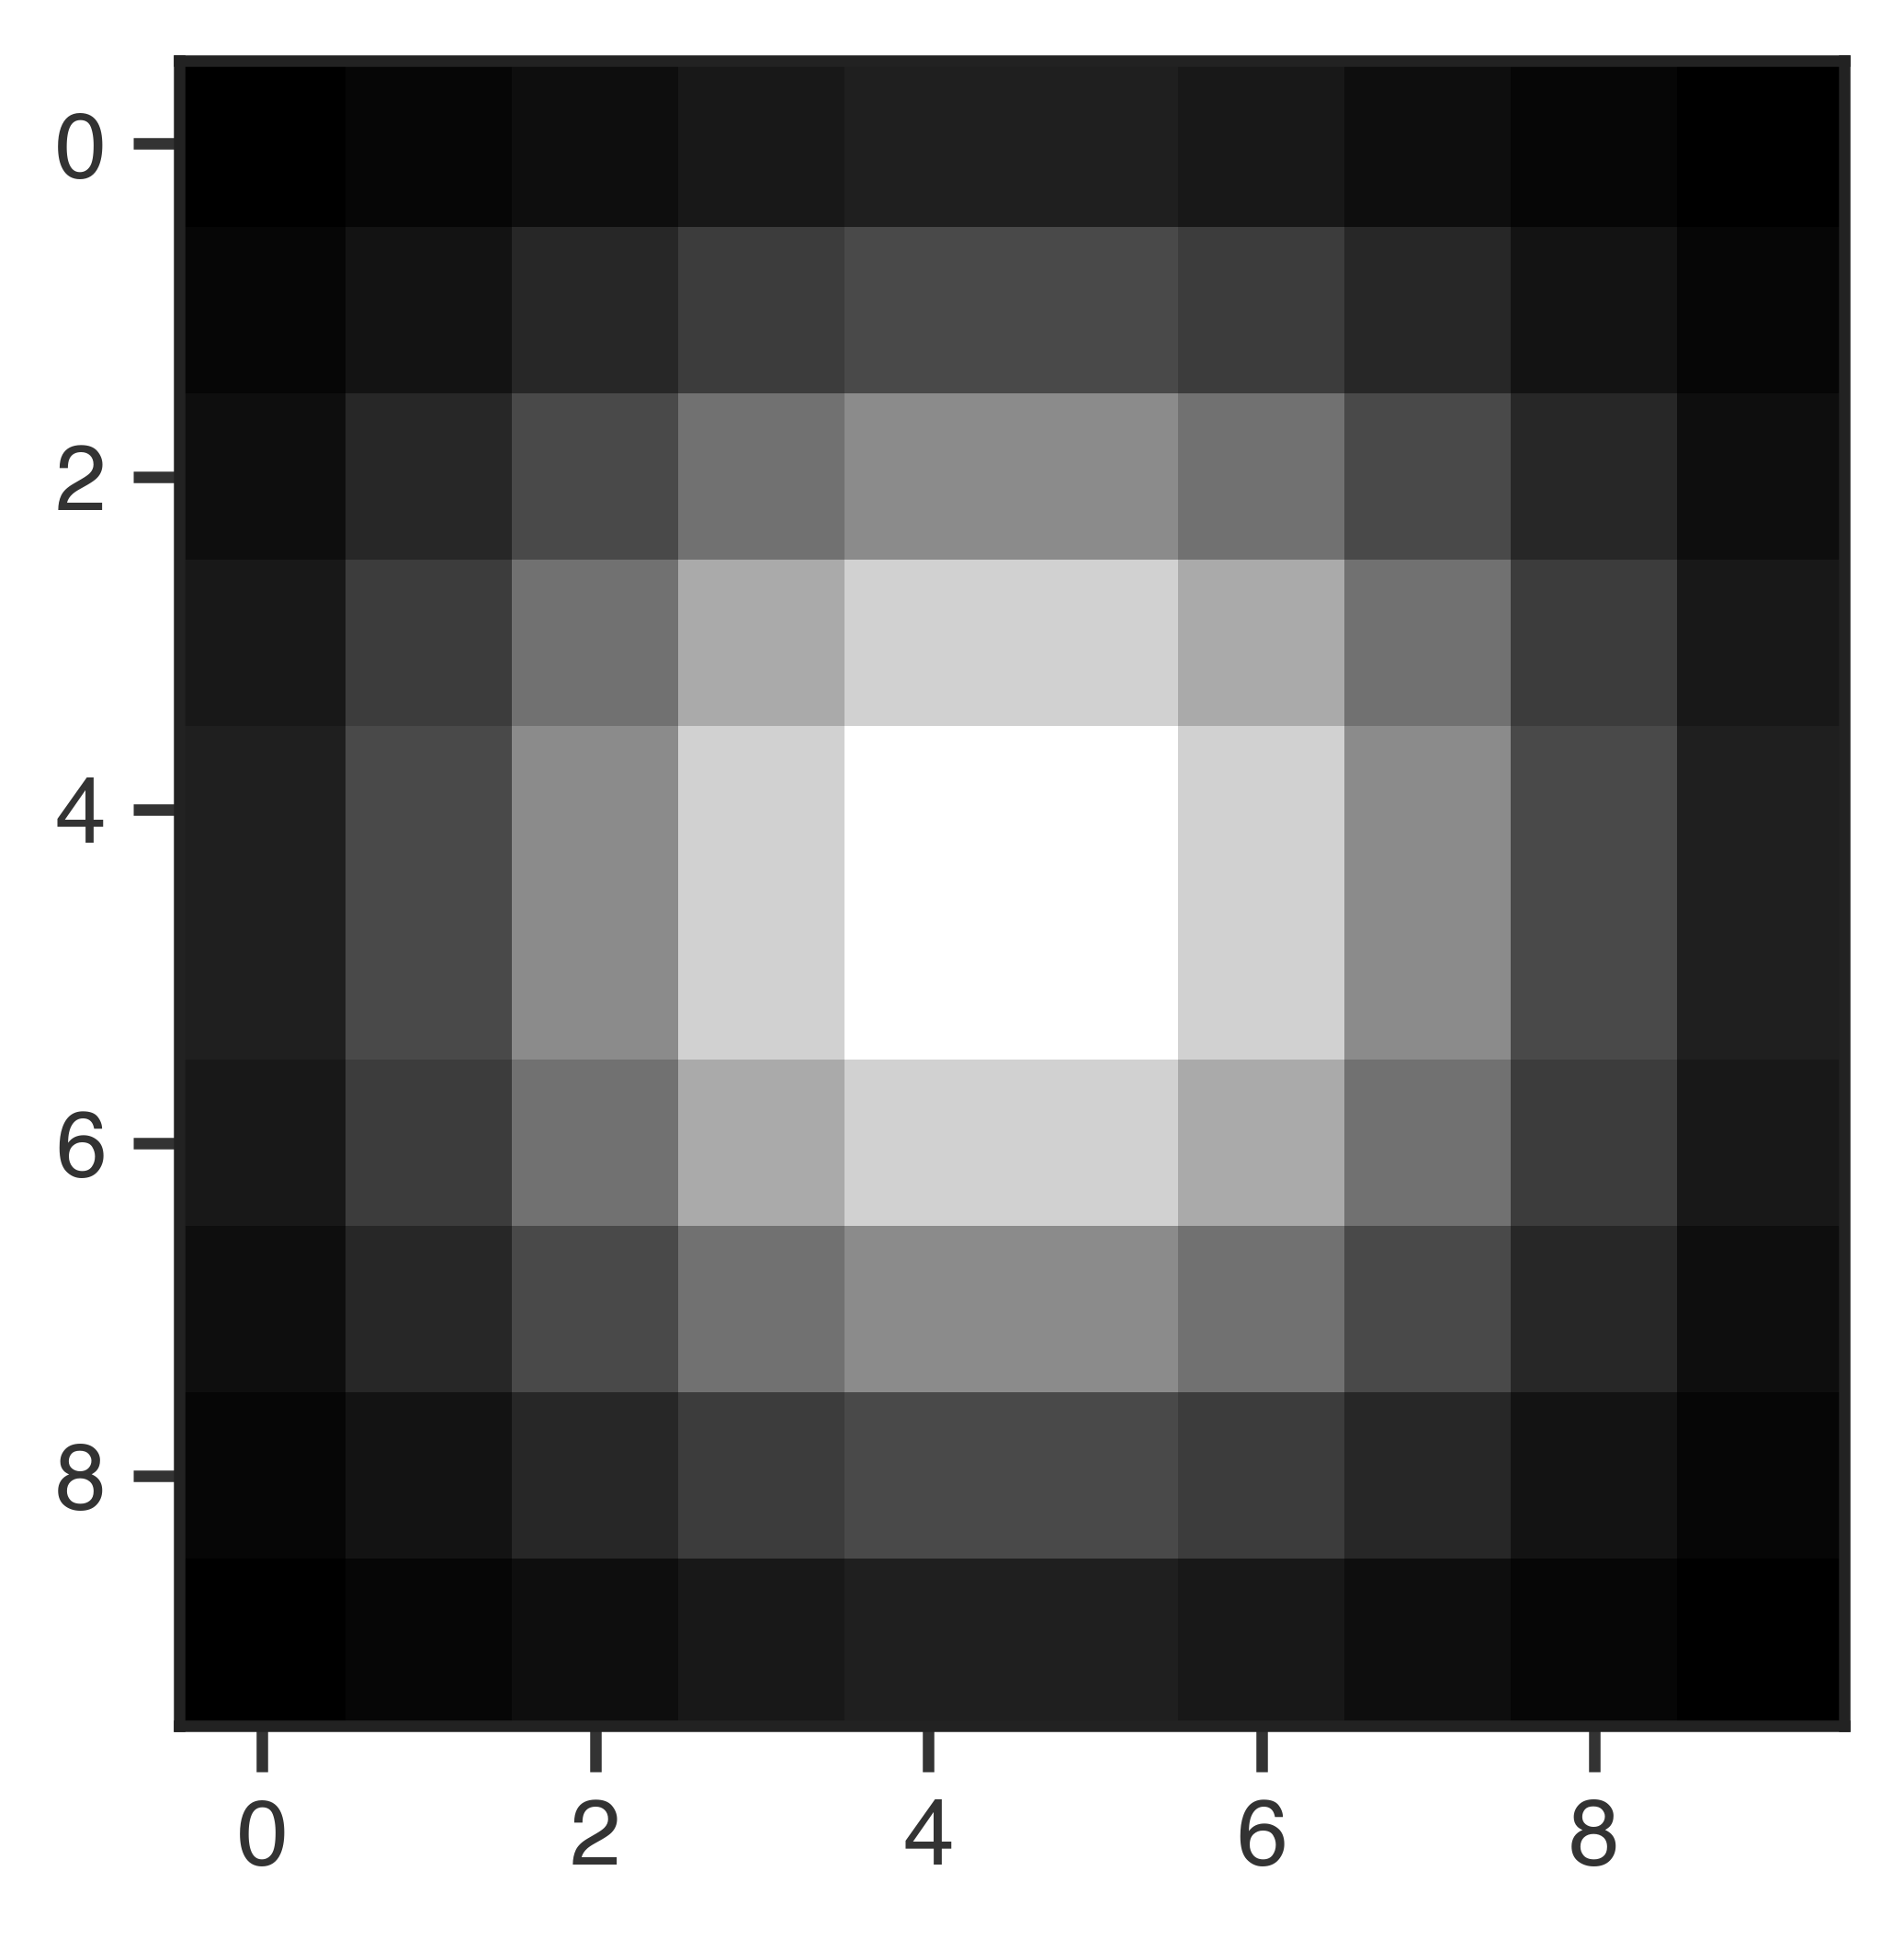

In [1179]:
plt.imshow(this_blur)

(-0.5, 248.5, 248.5, -0.5)

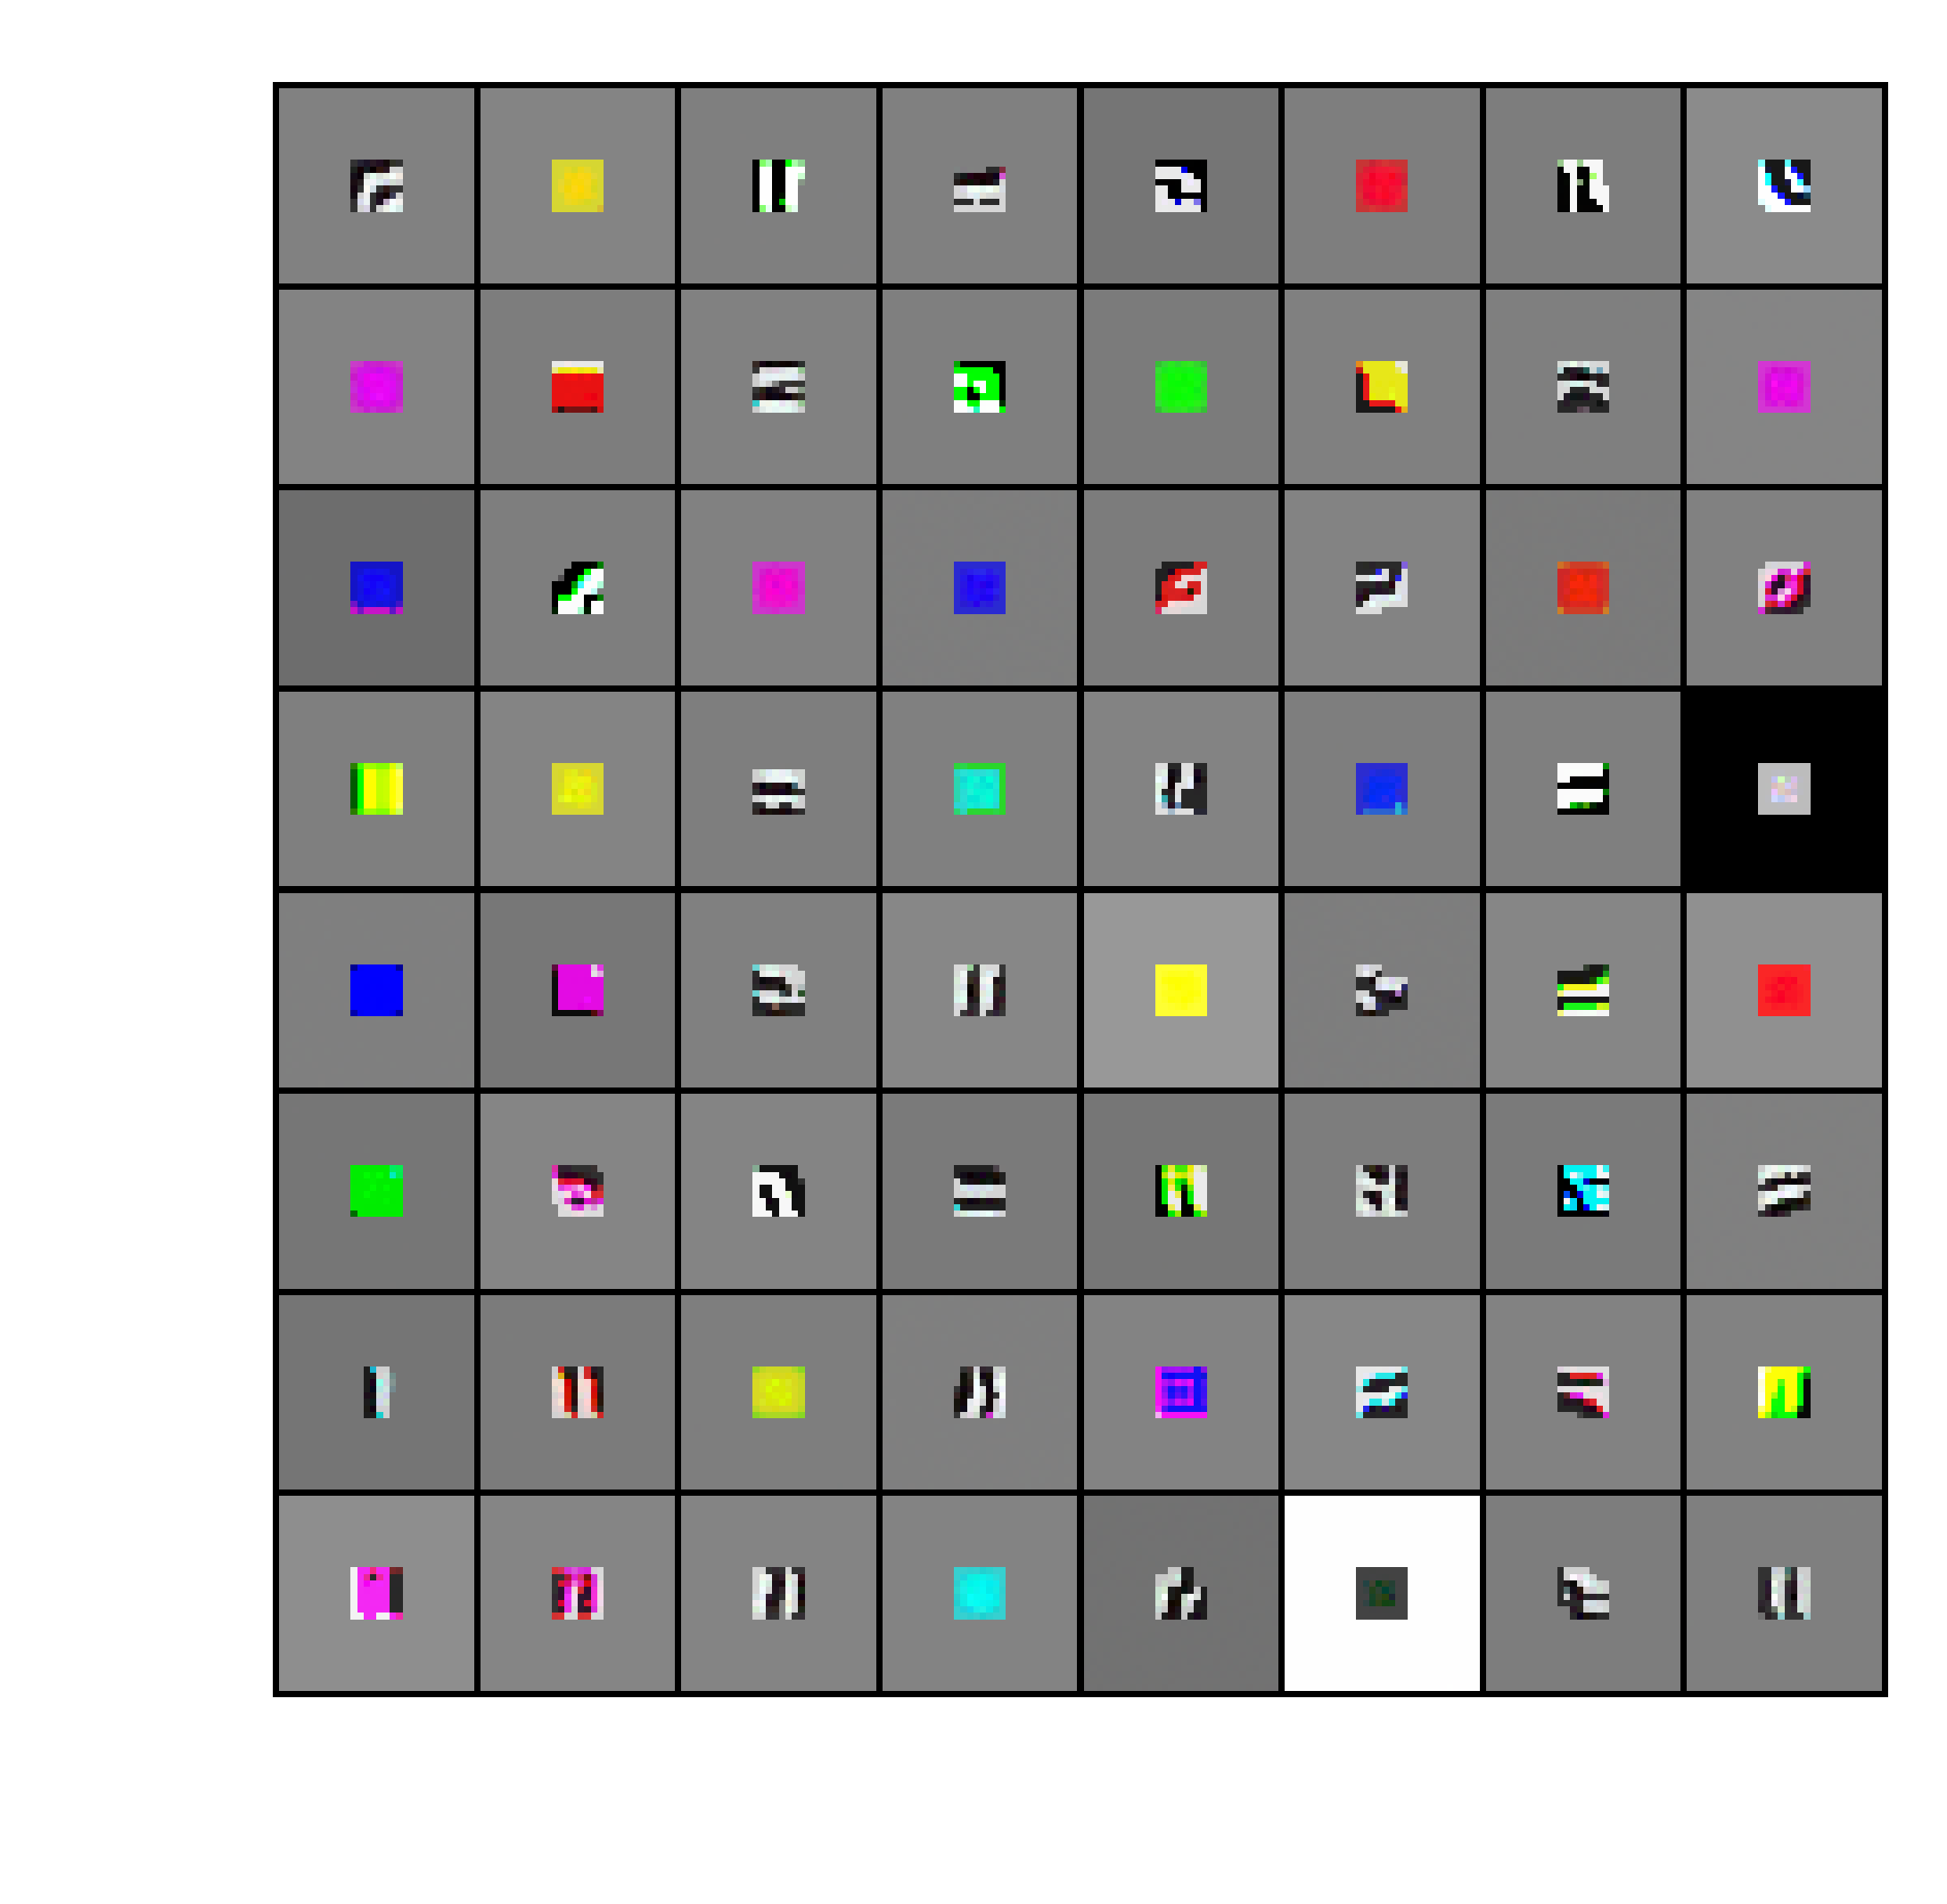

In [1153]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(single_unit_activation_maps['layer_13'][-64:]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m
    
plt.imshow(display_map)
plt.axis('off')

(-0.5, 248.5, 248.5, -0.5)

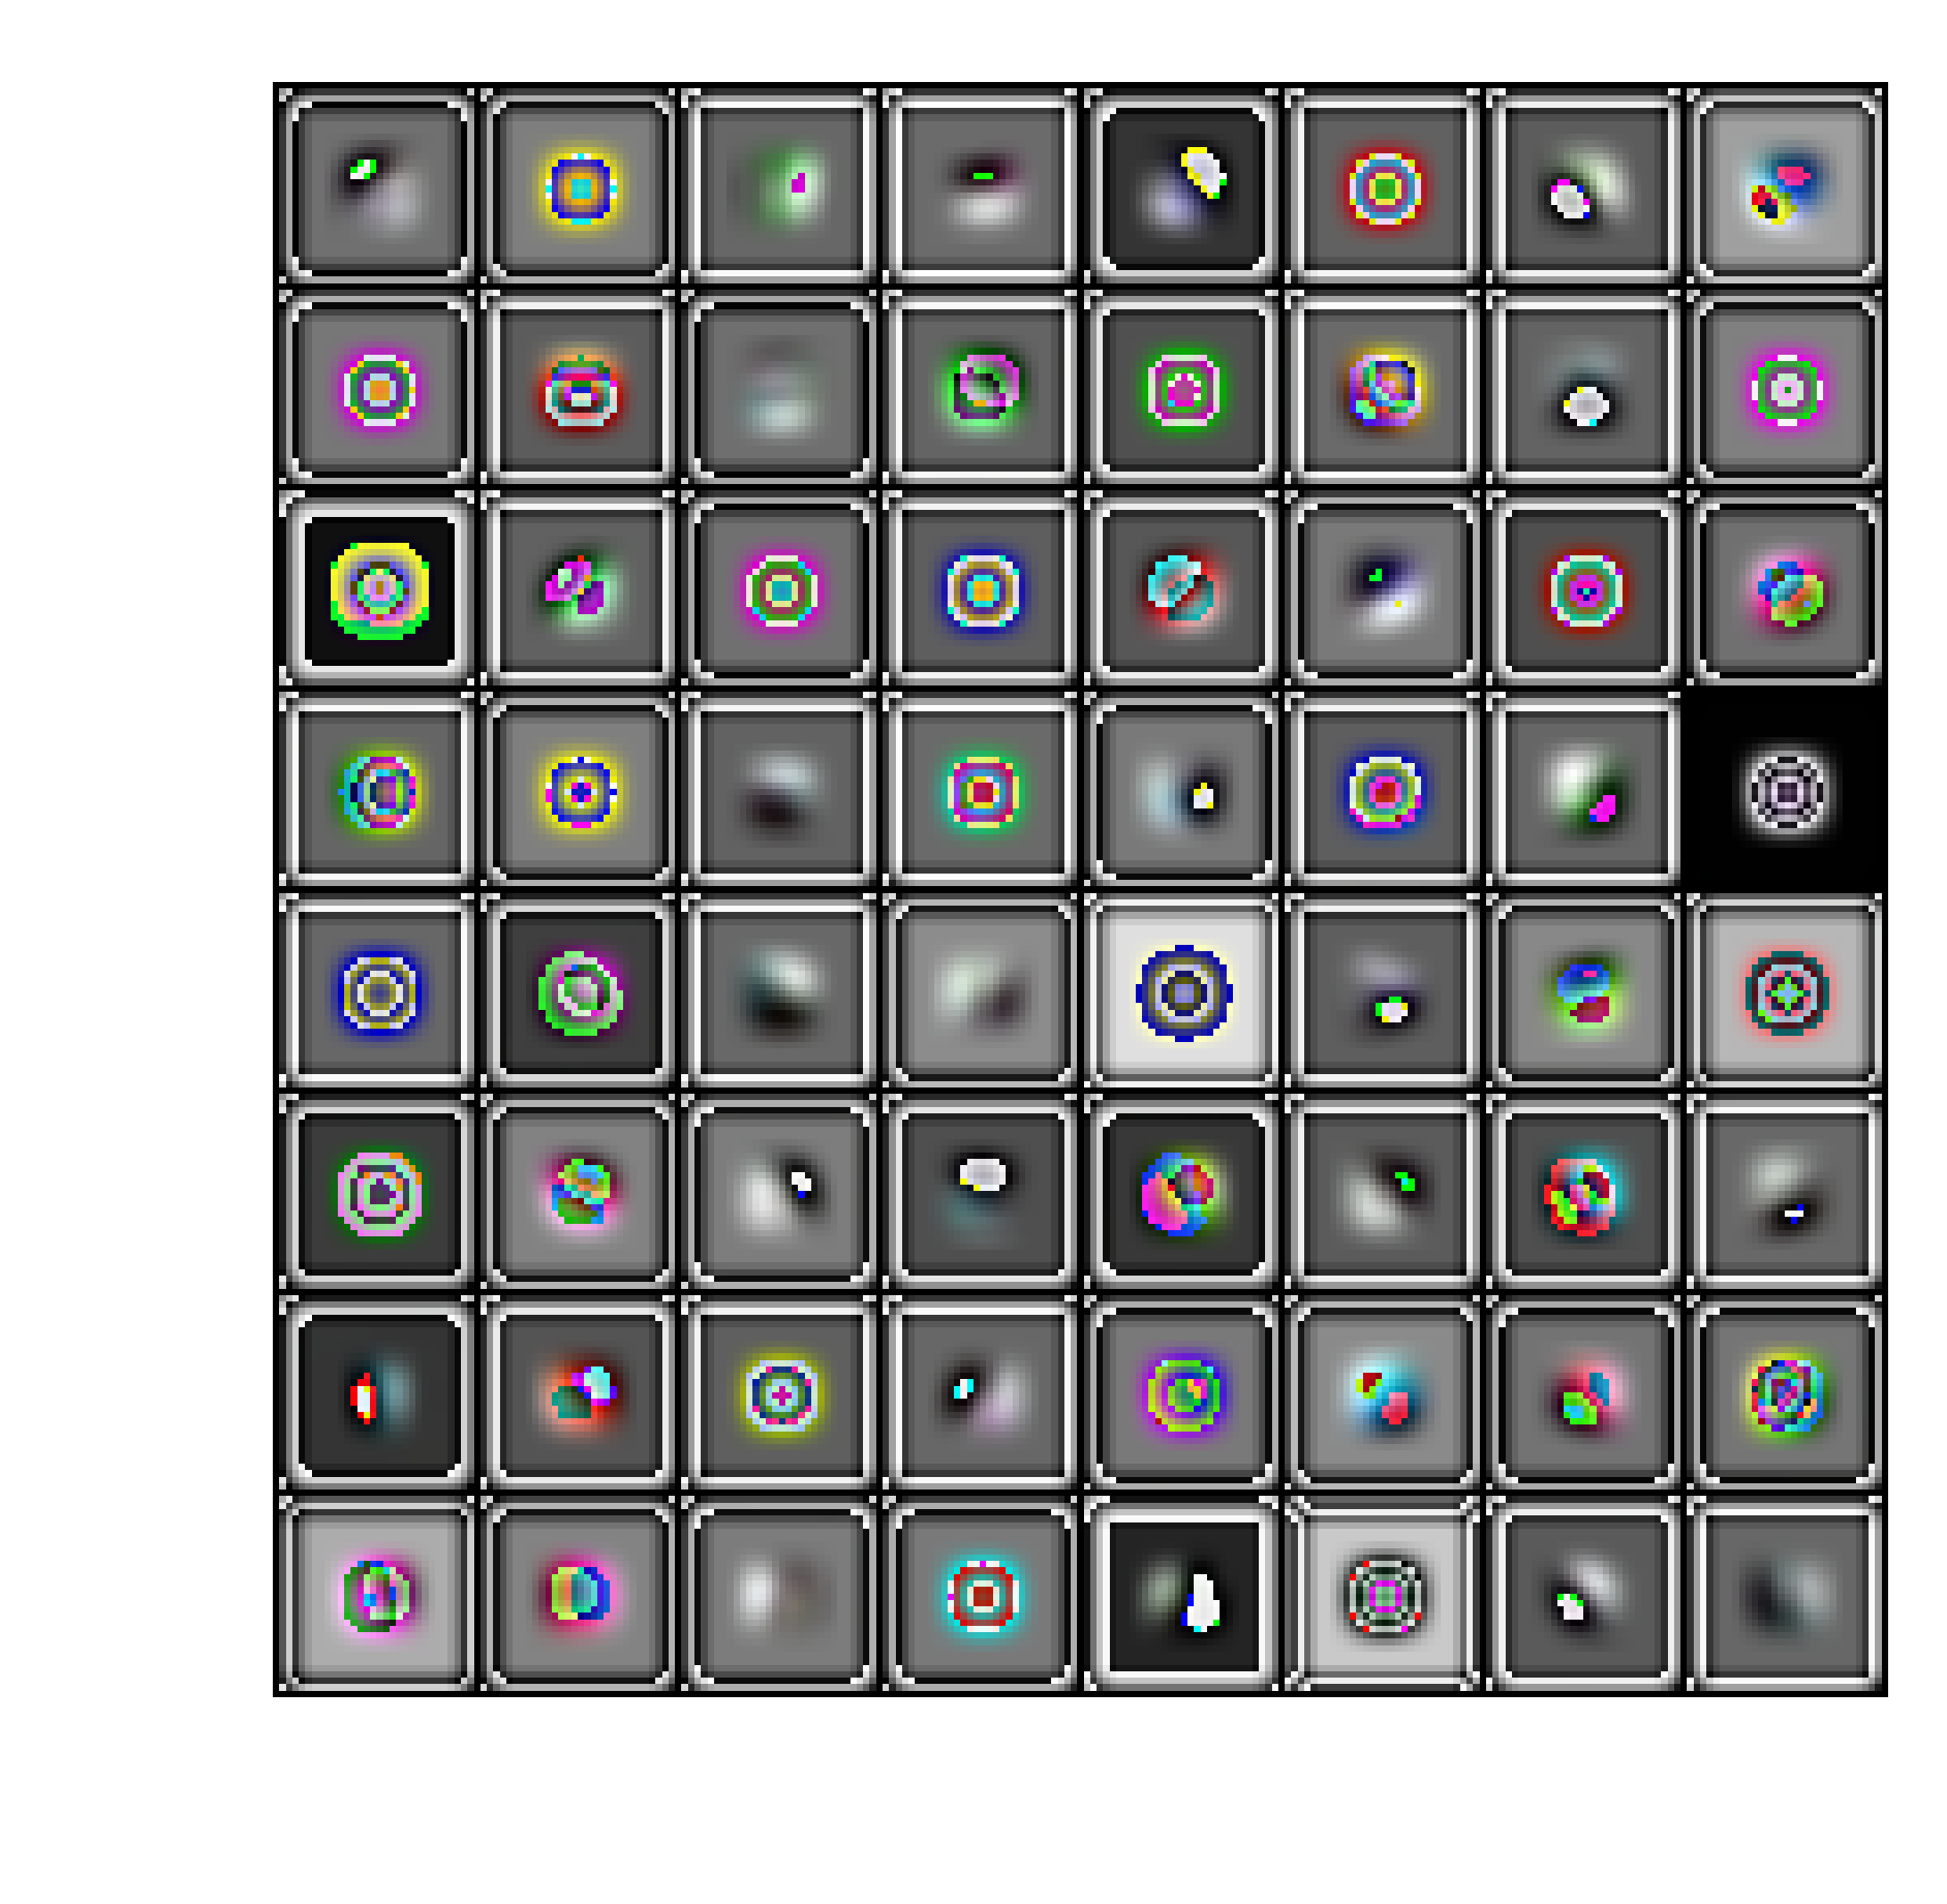

In [1185]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(single_unit_activation_maps['layer_13'][-64:]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    blurred_m = np.rollaxis(np.stack([convolve2d(m[:,:,i], this_blur, mode='same') for i in range(3)]), 0, 3)
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = blurred_m
    
plt.imshow(display_map)
plt.axis('off')

# First layer

In [1147]:
tf.reset_default_graph()
max_depth = 2 # must be less than 30 where FC layers start
height, width = (30,30)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []

# filter shape `[filter_height, filter_width, in_channels, out_channels]`
this_W = np.array(f['layer_1/param_0']).copy()
this_W = np.rollaxis(this_W, 0, 4)
this_W = np.rollaxis(this_W, 0, 3)
act_W = tf.nn.conv2d(X_clipped, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W = tf.nn.relu(act_W + np.array(f['layer_1/param_1']))
model.append(relu_W)
top_layer_reached = 'layer_1'
    
for i,layer in enumerate(sorted_layer_names):
    if list(f[layer]) and i <= max_depth and i > 2:
        this_W = np.array(f[layer + '/param_0']).copy()
        this_W = np.swapaxes(this_W, 1, 2)
        this_W = np.swapaxes(this_W, 0, 3)
        act_W = tf.nn.conv2d(relu_W, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        relu_W = tf.nn.relu(act_W + np.array(f[layer + '/param_1']))
        model.append(relu_W)
        
        top_layer_reached = layer

for i in tqdm(range(64)):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,12:18,12:18,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    single_unit_activation_maps[top_layer_reached].append(rescaled_img)

100%|██████████| 64/64 [02:02<00:00,  2.20s/it]


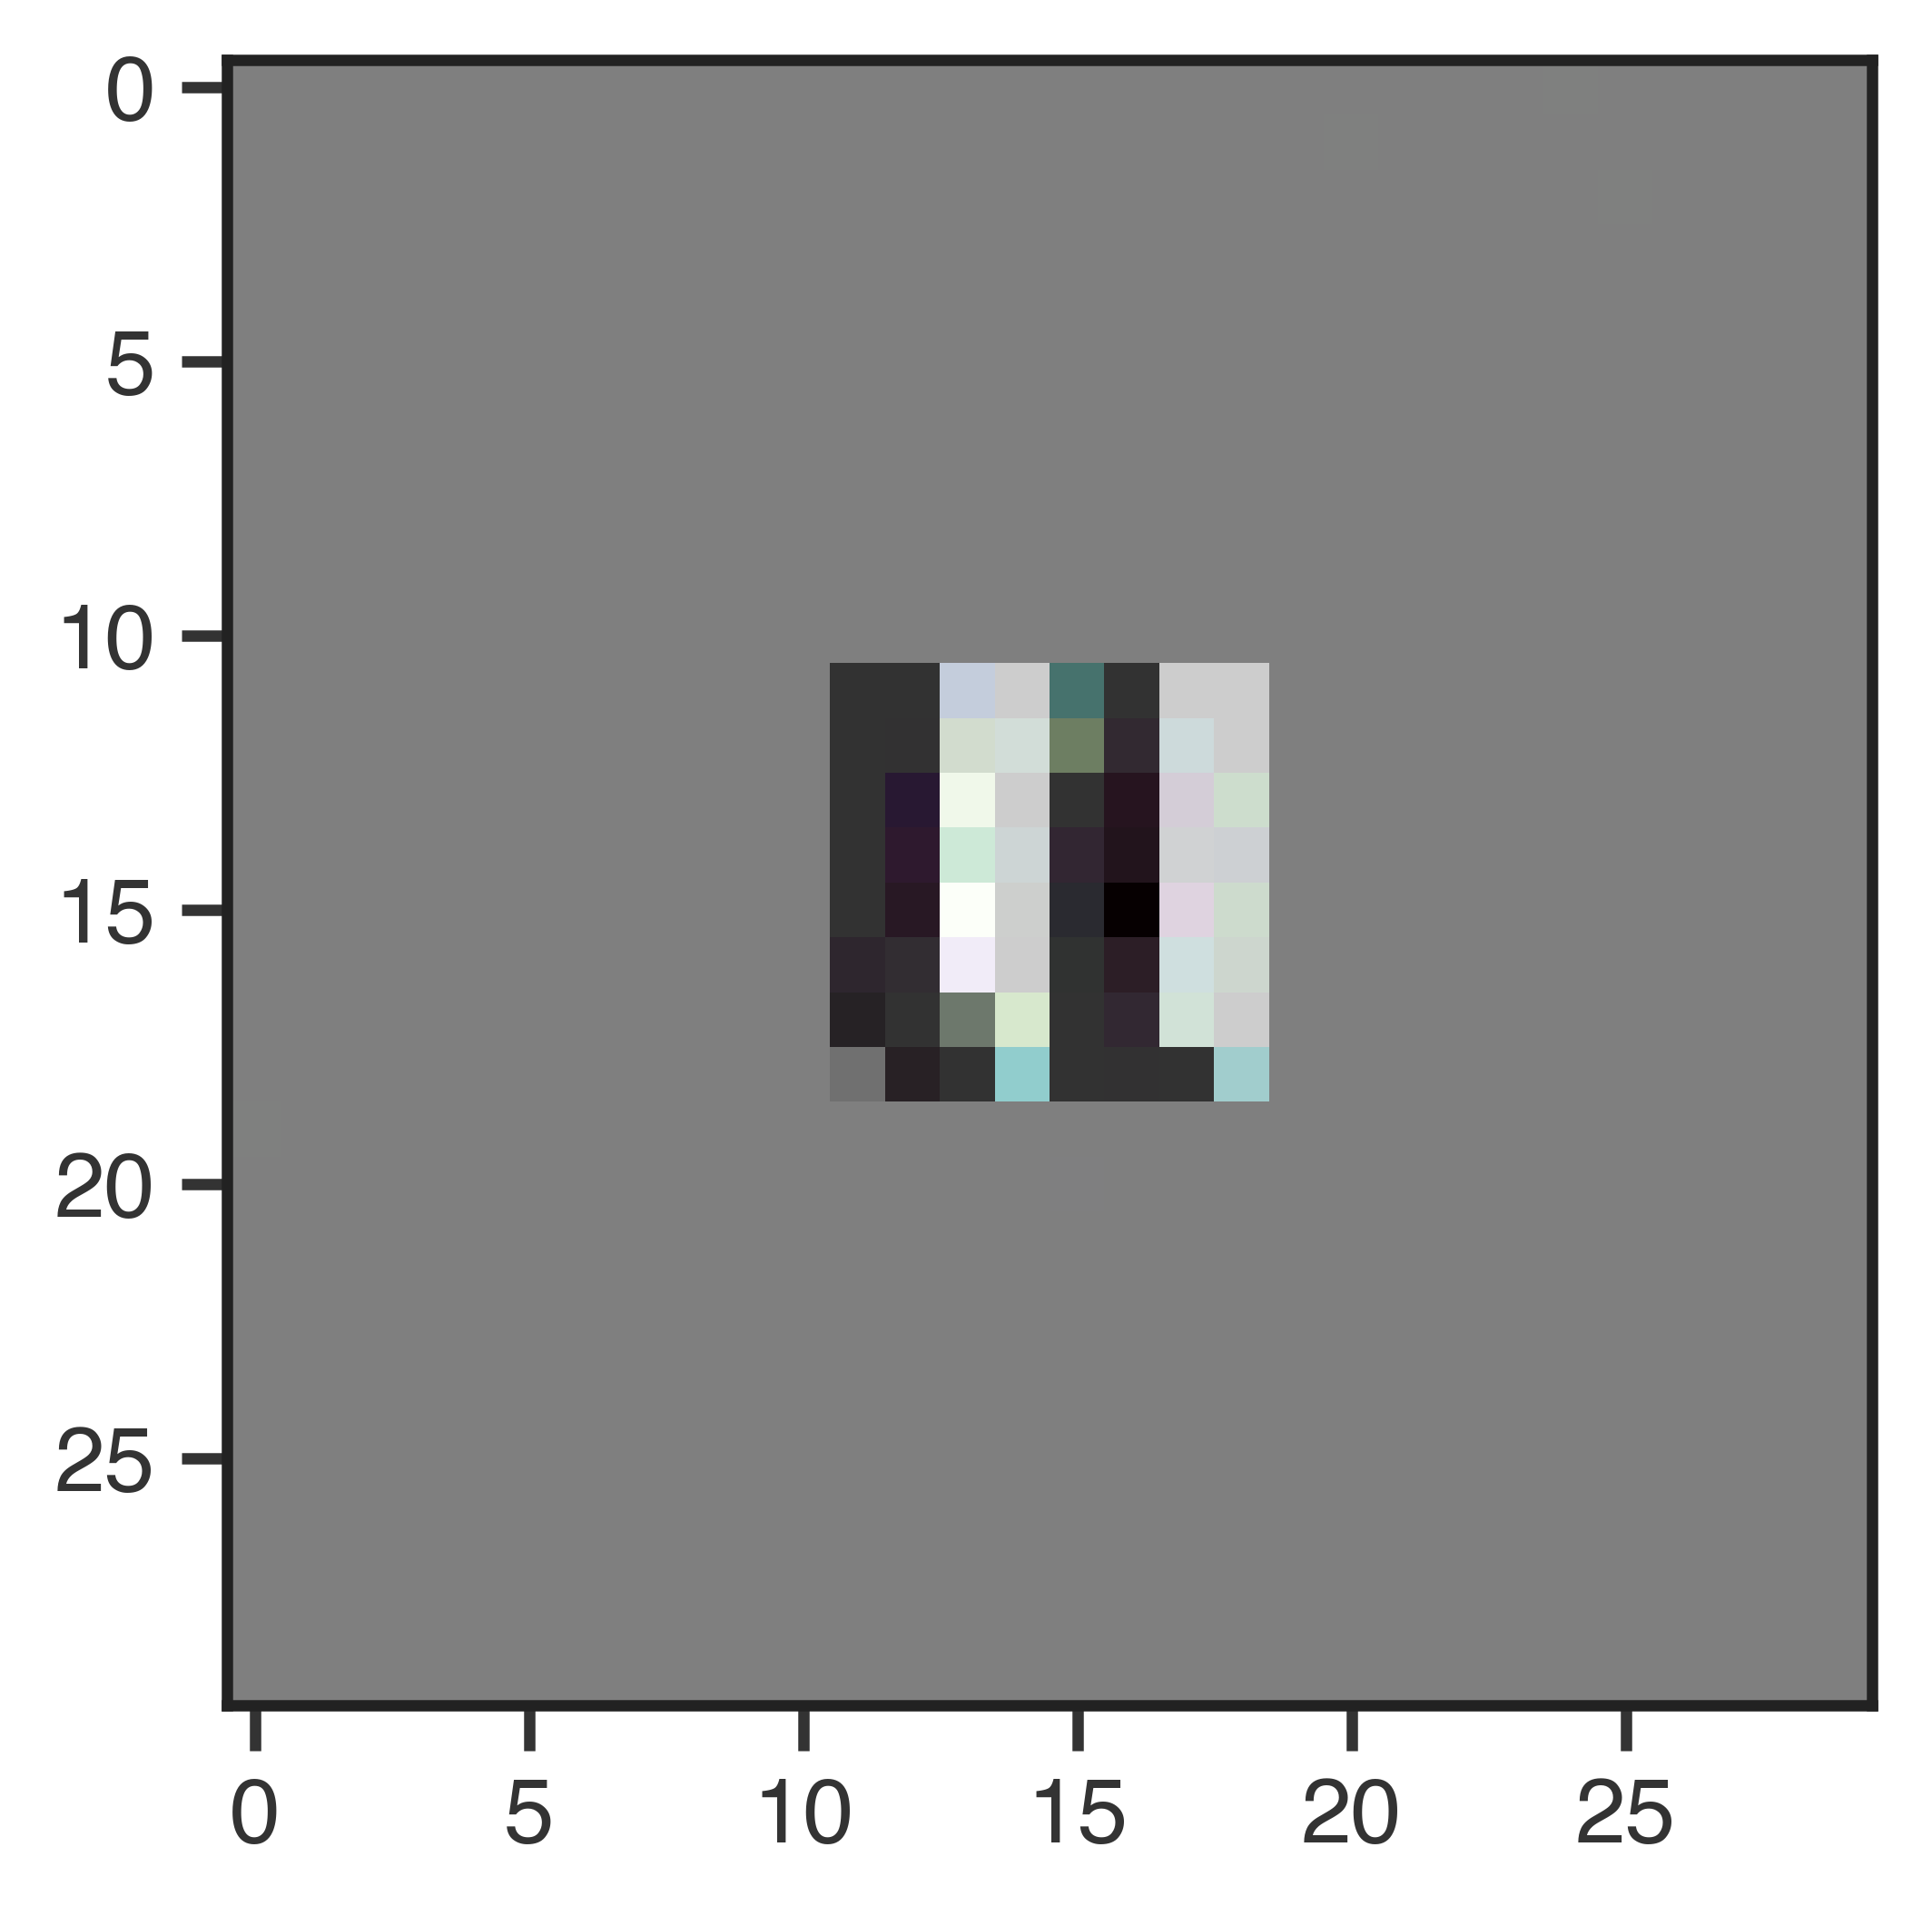

In [1152]:
plt.imshow(rescaled_img)

(-0.5, 248.5, 248.5, -0.5)

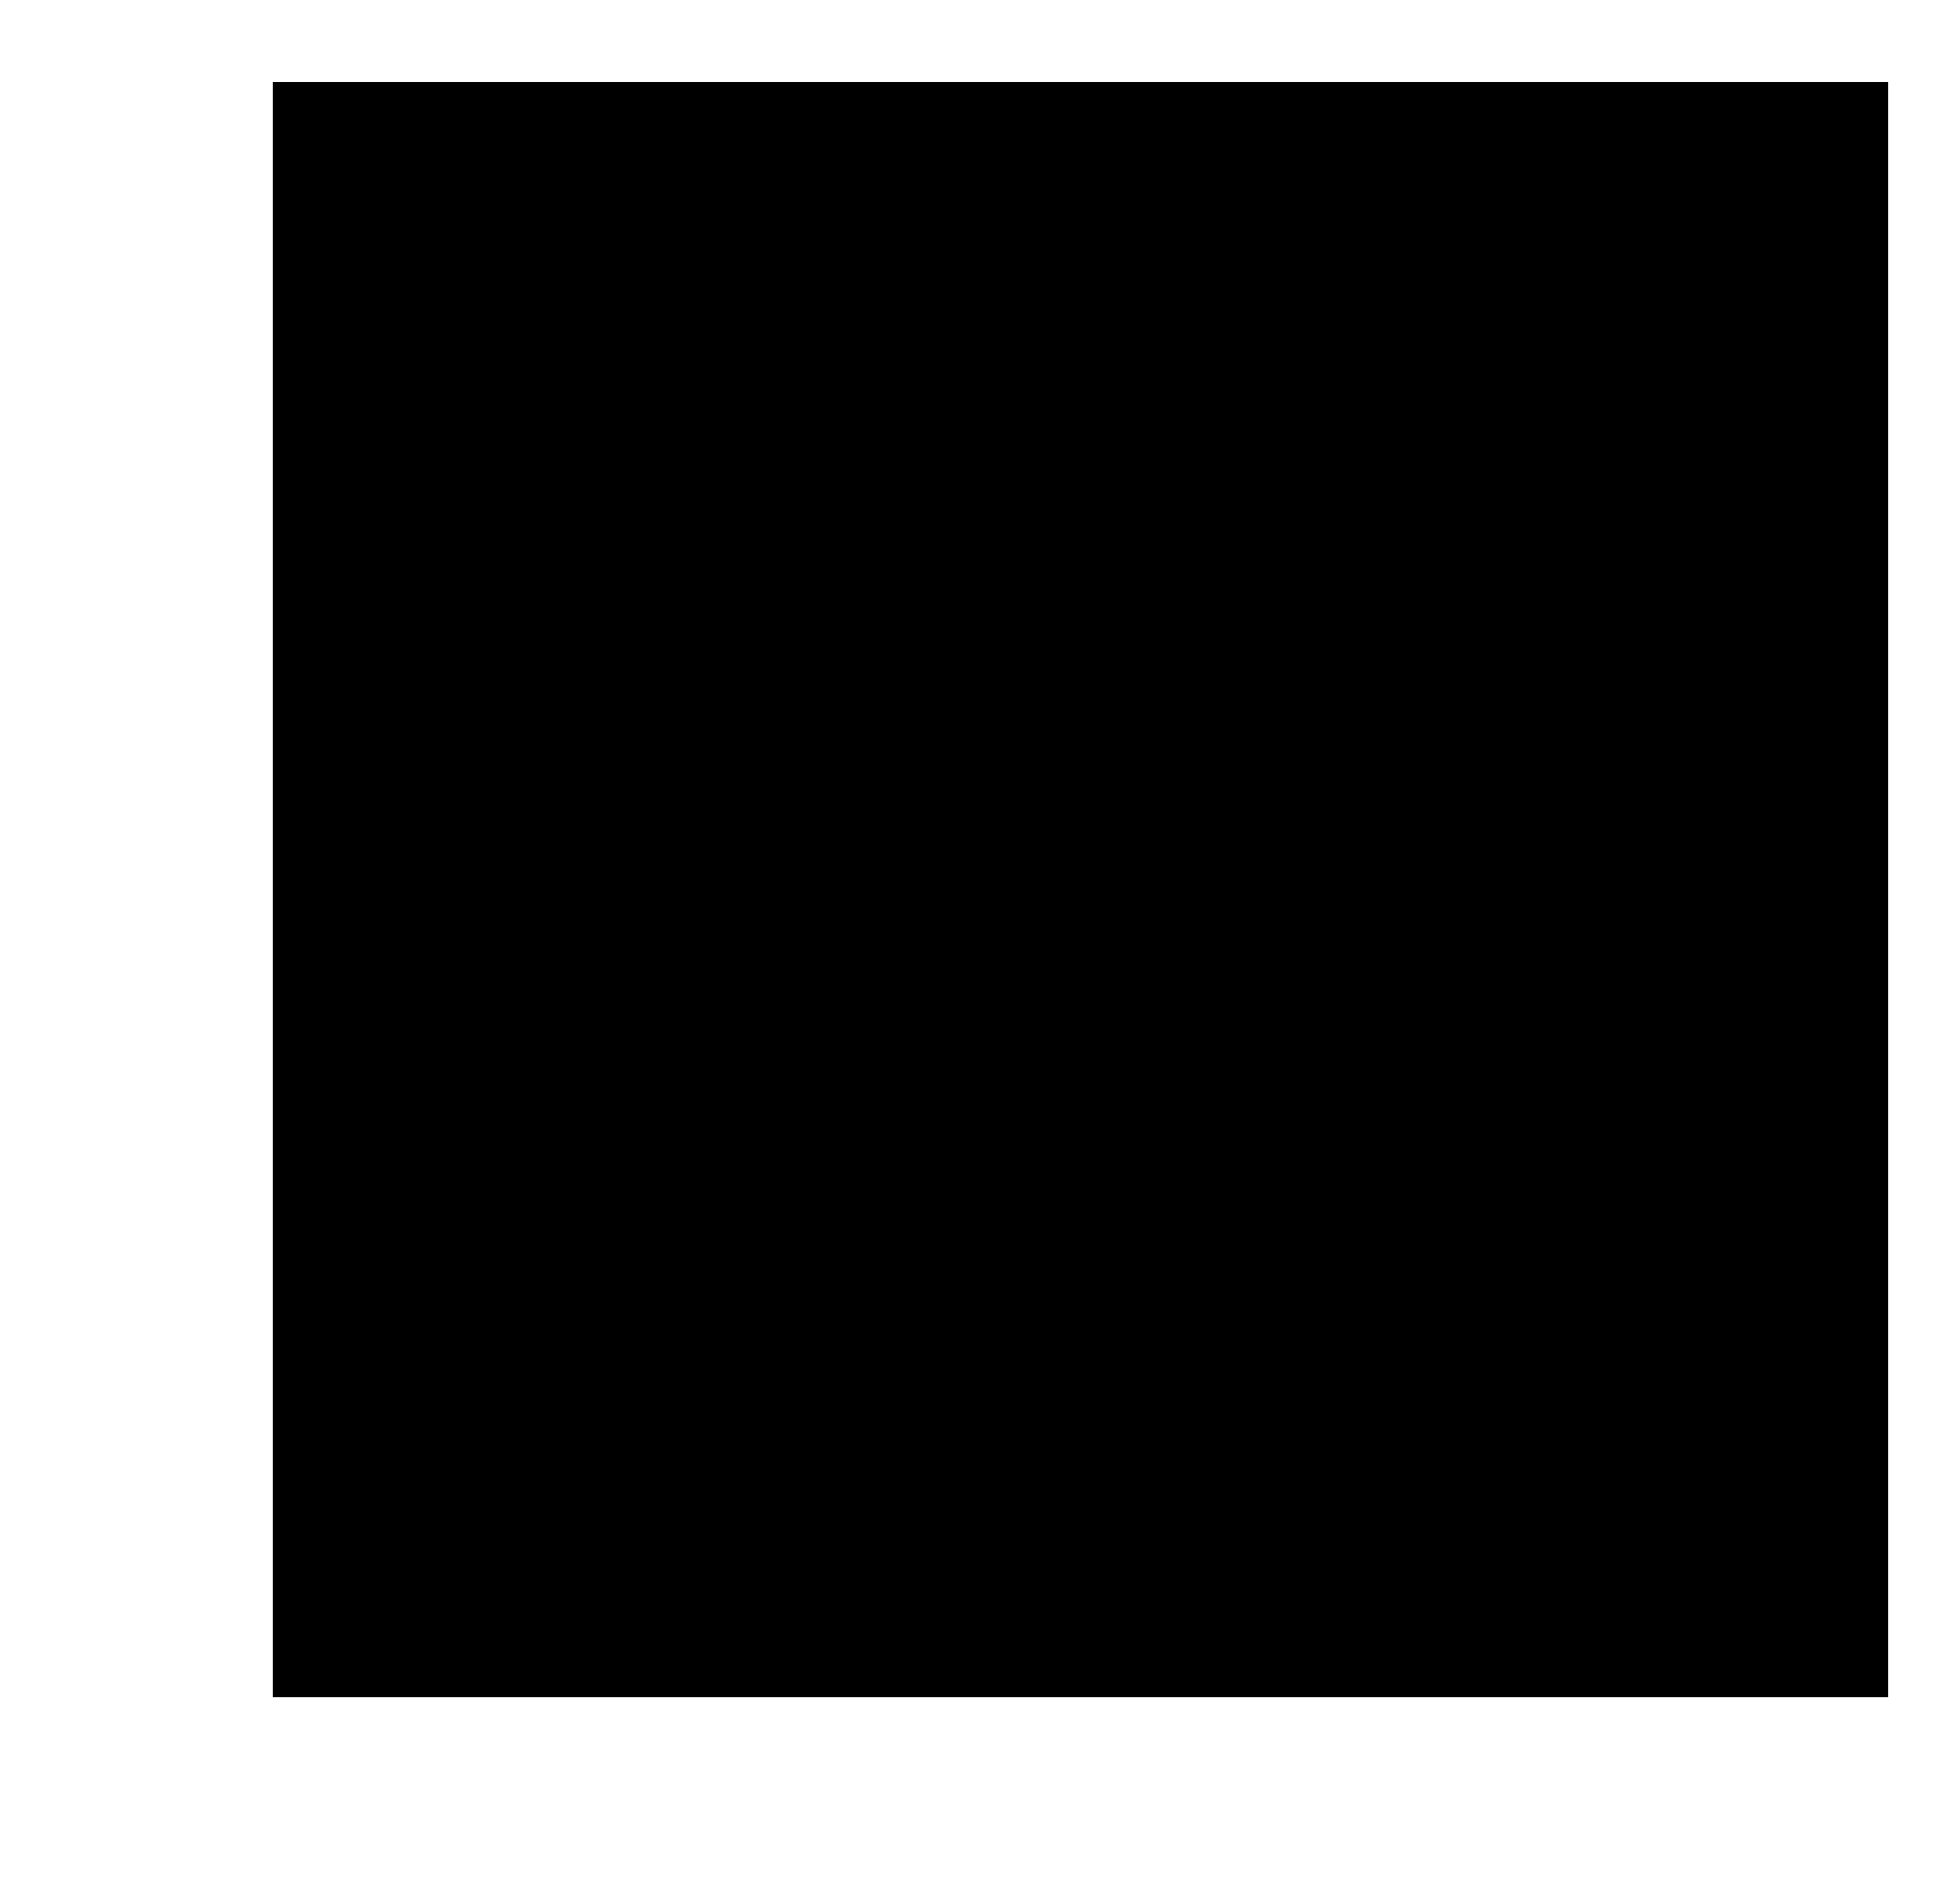

In [1151]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(single_unit_activation_maps['layer_1']):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m[:,:,[2,1,0]]
    
plt.imshow(display_map)
plt.axis('off')

# Layer 3

In [ ]:
tf.reset_default_graph()
max_depth = 4 # must be less than 30 where FC layers start
height, width = (30,30)
with tf.variable_scope('input'):
    # Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
    X = tf.get_variable("X", shape=(1,height,width,3), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0., stddev=10.))
    X_clipped = tf.clip_by_value(X, -128., 128.)

model = []

# filter shape `[filter_height, filter_width, in_channels, out_channels]`
this_W = np.array(f['layer_1/param_0']).copy()
this_W = np.rollaxis(this_W, 0, 4)
this_W = np.rollaxis(this_W, 0, 3)
act_W = tf.nn.conv2d(X_clipped, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
relu_W = tf.nn.relu(act_W + np.array(f['layer_1/param_1']))
model.append(relu_W)
    
for i,layer in enumerate(sorted_layer_names):
    if list(f[layer]) and i <= max_depth and i > 2:
        this_W = np.array(f[layer + '/param_0']).copy()
        this_W = np.swapaxes(this_W, 1, 2)
        this_W = np.swapaxes(this_W, 0, 3)
        act_W = tf.nn.conv2d(relu_W, this_W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
        relu_W = tf.nn.relu(act_W + np.array(f[layer + '/param_1']))
        model.append(relu_W)
        
        top_layer_reached = layer

for i in tqdm(range(64)):
    selected_unit = i
    l2_reg = 1e-1
    desirable_activity = -tf.nn.l2_loss(model[-1][0,12:18,12:18,selected_unit])
    undesirable_activity = -l2_reg * tf.nn.l2_loss(X)

    lr = tf.placeholder(tf.float32, shape=[])
    opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.99, beta2=0.99, epsilon=1e-08)
    grads = opt.compute_gradients(desirable_activity - undesirable_activity)
    train_op = opt.apply_gradients(grads)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    iterations = 1000
    this_lr = 10.

    for it in range(iterations):
        g = sess.run([train_op], feed_dict={lr: this_lr})
        
        if it % 500 == 0:
            this_lr *= 0.1
            
    maximal_image = sess.run(X)
    # rescale to be in [0,1]
    rescaled_img = (maximal_image[0,:,:,:] - np.min(maximal_image[0,:,:,:]))
    rescaled_img /= np.max(rescaled_img)
    single_unit_activation_maps[top_layer_reached].append(rescaled_img)

In [ ]:
display_map = np.zeros(((height+1)*8 + 1, (width+1)*8 + 1, 3)) # black with one pixel in between each map
for idm,m in enumerate(single_unit_activation_maps['layer_3'][-64:]):
    ycoord = int(idm/8.0)
    xcoord = idm % 8
    display_map[(1+ycoord*(height+1)):((ycoord+1)*(height+1)), (1+(xcoord)*(width+1)):((xcoord+1)*(width+1))] = m[:,:,[2,1,0]]
    
plt.imshow(display_map)
plt.axis('off')